#**Skforecast: forecasting series temporales con Python, Machine Learning y Scikit-learn**

# **Introducción**
Una serie temporal (time series) es una sucesión de datos ordenados cronológicamente, espaciados a intervalos iguales o desiguales. El proceso de forecasting consiste en predecir el valor futuro de una serie temporal, bien modelando la serie únicamente en función de su comportamiento pasado (autorregresivo) o empleando otras variables externas.

Esta guía describe cómo utilizar modelos de regresión de Scikit-learn para realizar forecasting de series temporales. En concreto, se hace uso de Skforecast, una librería que contiene las clases y funciones necesarias para adaptar cualquier modelo de regresión de Scikit-learn a problemas de forecasting.

# **✎ Nota**

Este documento sirve como guía introductoria al forecasting con machine learning utilizando skforecast. Para ejemplos más avanzados y detallados, consultar:
Forecasting series temporales con gradient boosting: XGBoost, LightGBM y CatBoost
Predicción de la demanda eléctrica con machine learning
# **Entrenamiento de un modelo de forecasting**
La principal adaptación que se necesita hacer para aplicar modelos de machine learning a problemas de forecasting es transformar la serie temporal en un matriz en la que, cada valor, está asociado a la ventana temporal (lags) que le precede.


# **Predicciones multi-step**
Cuando se trabaja con series temporales, raramente se quiere predecir solo el siguiente elemento de la serie ( t+1
 ), sino todo un intervalo futuro o un punto alejado en el tiempo ( t+n
 ). A cada paso de predicción se le conoce como step. Existen varias estrategias que permiten generar este tipo de predicciones múltiples.

# **Recursive multi-step forecasting**
Dado que, para predecir el momento  tn
  se necesita el valor de  tn−1
 , y  tn−1
  se desconoce, se sigue un proceso recursivo en el que, cada nueva predicción, hace uso de la predicción anterior. A este proceso se le conoce como recursive forecasting o recursive multi-step forecasting y pueden generarse fácilmente con la clase ForecasterRecursive de la librería skforecast.


# **Direct multi-step forecasting**
El método direct multi-step forecasting consiste en entrenar un modelo distinto para cada step. Por ejemplo, si se quieren predecir los siguientes 5 valores de una serie temporal, se entrenan 5 modelos distintos, uno para cada step. Como resultado, las predicciones son independientes unas de otras.

La principal complejidad de esta aproximación consiste en generar correctamente las matrices de entrenamiento para cada modelo. Todo este proceso está automatizado en la clase ForecasterDirect de la librería skforecast. También es importante tener en cuenta que esta estrategia tiene un coste computacional más elevado ya que requiere entrenar múltiples modelos. En el siguiente esquema se muestra el proceso para un caso en el que se dispone de la variable respuesta y dos variables exógenas.

#**Forecasting multi-output**
Determinados modelos, por ejemplo, las redes neuronales LSTM, son capaces de predecir de forma simultánea varios valores de una secuencia (one-shot). Esta estrategia está disponible con la clase ForecasterRnn de la librería skforecast.

#**Librerías**
Las librerías utilizadas en este documento son:

In [ ]:
# ========================
# Instalación de Skforecast
# ========================

!pip install -q skforecast==0.13.0

# ===========================
# Importación de Bibliotecas
# ===========================
# Tratamiento de datos
import numpy as np
import pandas as pd
import skforecast  # Añadido para importar skforecast
import sklearn  # Añadido para importar sklearn
from skforecast.datasets import fetch_dataset  # Carga datasets predefinidos de Skforecast
#
# Visualización de datos
#
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')  # Estilo visual moderno y claro
plt.rcParams.update({
    'lines.linewidth': 1.5,  # Grosor de líneas en gráficos
    'font.size': 10          # Tamaño de fuente
})

# Modelado y Forecasting
from sklearn.linear_model import Ridge  # Regresión Ridge
from sklearn.ensemble import RandomForestRegressor  # Bosque aleatorio
from sklearn.metrics import mean_squared_error, mean_absolute_error  # Métricas de evaluación
from sklearn.preprocessing import StandardScaler  # Escalado de datos

# Skforecast: herramientas clave
from skforecast.ForecasterAutoreg import ForecasterAutoreg                   # Modelo autorregresivo
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom       # Autorregresivo personalizado
from skforecast.ForecasterAutoregDirect import ForecasterAutoregDirect       # Autorregresivo directo
from skforecast.model_selection import grid_search_forecaster, backtesting_forecaster  # Validación y selección de modelos
from skforecast.utils import save_forecaster, load_forecaster                # Guardado y carga de modelos

# Interpretabilidad de modelos
import shap  # SHAP para la interpretación de variables

# Configuración de advertencias
import warnings
warnings.filterwarnings('once')  # Mostrar cada advertencia solo una vez

# =====================
# Visualización de versiones
# =====================
# Mostrar versiones clave de bibliotecas utilizadas
print("\033[1m\033[38;5;208m--- Versiones de bibliotecas ---\033[0m")
print(f"Skforecast:     {skforecast.__version__}")
print(f"Scikit-learn:   {sklearn.__version__}")
print(f"Pandas:         {pd.__version__}")
print(f"Numpy:          {np.__version__}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.5/670.5 kB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 20.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 12.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 4.9 MB/s eta 0:00:00
--- Versiones de bibliotecas ---
Skforecast:     0.13.0
Scikit-learn:   1.5.2
Pandas:         2.2.2
Numpy:          1.26.4


# **Datos**
Se dispone de una serie temporal con el gasto mensual (millones de dólares) en fármacos con corticoides que tuvo el sistema de salud Australiano entre 1991 y 2008. Se pretende crear un modelo autoregresivo capaz de predecir el futuro gasto mensual. Los datos empleados en los ejemplos de este documento se han obtenido del magnífico libro Forecasting: Principles and Practice by Rob J Hyndman and George Athanasopoulos.

In [2]:
# Descarga de datos
# ==============================================================================

import pandas as pd

# Cargar los datos desde el archivo Excel
datos = pd.read_excel('/content/datos_ingenieria.xlsx')

# Mostrar únicamente las primeras filas del DataFrame
datos.head()


fecha  temperatura      presion  velocviento   humendad  \
0  1910-01-01    17.490802  1015.791540     3.285316  48.826402   
1  1910-01-02    29.014286  1024.417858    16.291494  51.024310   
2  1910-01-03    24.639879  1023.580260    13.303944  49.321913   
3  1910-01-04    21.973170  1012.936867    10.461308  78.979224   
4  1910-01-05    13.120373  1011.040420     7.176610  57.506263   

   produc_energia  
0      454.477965  
1      686.109679  
2      195.933727  
3      692.060774  
4      999.472353

# <font color="">**Preparando el dataset**</font>

La columna fecha, almacenada como texto, se convierte al formato datetime usando la función pd.to_datetime(). Luego, se establece como índice del DataFrame para aprovechar las funcionalidades de Pandas en el manejo de series temporales. Finalmente, dado que los datos son mensuales, se define la frecuencia como "inicio de mes" (MS).

In [3]:
# Procesamiento del DataFrame para manejo de series temporales
# ==============================================================================

import pandas as pd

# Cargar los datos desde el archivo Excel
datos = pd.read_excel('/content/datos_ingenieria.xlsx')

# Convertir la columna 'fecha' a formato datetime
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')

# Establecer 'fecha' como índice
datos = datos.set_index('fecha')

# Definir la frecuencia mensual (MS: inicio del mes)
datos = datos.asfreq('MS')

# Ordenar los datos por índice (fecha)
datos = datos.sort_index()

# Mostrar solo las primeras filas procesadas
datos.head()


temperatura      presion  velocviento   humendad  produc_energia
fecha                                                                       
1910-01-01    17.490802  1015.791540     3.285316  48.826402      454.477965
1910-02-01    13.410482  1022.876191     6.234441  44.349338      435.926612
1910-03-01    16.506607  1010.863381    18.945667  70.930569      934.331090
1910-04-01    12.391885  1017.389377    16.057069  86.861424      956.263008
1910-05-01    26.148803  1023.517370     1.341530  51.038481      308.752387

In [4]:
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


# **Verificar que un índice temporal está completo**

In [5]:
fecha_inicio = datos.index.min()
fecha_fin = datos.index.max()
date_range_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq=datos.index.freq)
print(f"Índice completo: {(datos.index == date_range_completo).all()}")

Índice completo: True


In [6]:
# Cargar los datos desde el archivo Excel
datos = pd.read_excel('/content/datos_ingenieria.xlsx')

# Convertir la columna 'fecha' al tipo datetime para trabajar con series temporales
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')

# Establecer la columna 'fecha' como índice del DataFrame
datos.set_index('fecha', inplace=True)

# Asegurar que los datos tengan una frecuencia mensual (MS: Month Start)
datos = datos.asfreq('MS')

# Mostrar las primeras filas para verificar los datos cargados
datos.head()


temperatura      presion  velocviento   humendad  produc_energia
fecha                                                                       
1910-01-01    17.490802  1015.791540     3.285316  48.826402      454.477965
1910-02-01    13.410482  1022.876191     6.234441  44.349338      435.926612
1910-03-01    16.506607  1010.863381    18.945667  70.930569      934.331090
1910-04-01    12.391885  1017.389377    16.057069  86.861424      956.263008
1910-05-01    26.148803  1023.517370     1.341530  51.038481      308.752387

In [ ]:
print(f'Número de filas con missing values: {datos.isnull().any(axis=1).mean()}')

Número de filas con missing values: 0.0


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Verificar que un índice temporal está completo
# ==============================================================================
fecha_inicio = datos.index.min()
fecha_fin = datos.index.max()
date_range_completo = pd.date_range(start=fecha_inicio, end=fecha_fin, freq=datos.index.freq)
print(f"Índice completo: {(datos.index == date_range_completo).all()}")

Índice completo: True


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Completar huecos en un índice temporal
# ==============================================================================
# datos.asfreq(freq='30min', fill_value=np.nan)

# **Separación datos train-test**

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


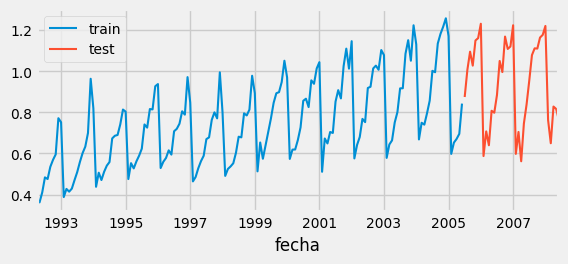

In [ ]:
# Separación datos train-test
# ==============================================================================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
ax.legend();

# **Forecasting autorregresivo recursivo**
## **ForecasterRecursive**
Se crea y entrena un modelo ForecasterRecursive a partir de un regresor RandomForestRegressor y una ventana temporal de 6 lags. Esto último significa que, el modelo, utiliza como predictores los 6 meses anteriores.

# **INICIO DEL MODELAMIENTO**

**Forecasting autorregresivo recursivo**

**`ForecasterAutoreg`**. Se crea y entrena un modelo ForecasterAutoreg a partir de un regresor RandomForestRegressor y una ventana temporal de 6 lags. Esto último significa que, el modelo, utiliza como predictores los 6 meses anteriores.

In [ ]:
# Crear y entrenar forecaster
# ==============================================================================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )
forecaster.fit(y=datos_train['y'])
forecaster

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bo

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6] 
Transformer for y: None 
Transformer for exog: None 
Window size: 6 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-12-16 00:14:56 
Last fit date: 2024-12-16 00:14:56 
Skforecast version: 0.13.0 
Python version: 3.10.12 
Fo

##**Predicciones**</font>

Una vez entrenado el modelo, se predicen los datos de test (36 meses).

In [ ]:
steps = 36
predicciones = forecaster.predict(steps=steps)
predicciones.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2005-07-01    0.878756
2005-08-01    0.882167
2005-09-01    0.973184
2005-10-01    0.983678
2005-11-01    0.849494
Freq: MS, Name: pred, dtype: float64

## **Gráfico de predicciones vs valores reales**</font>

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


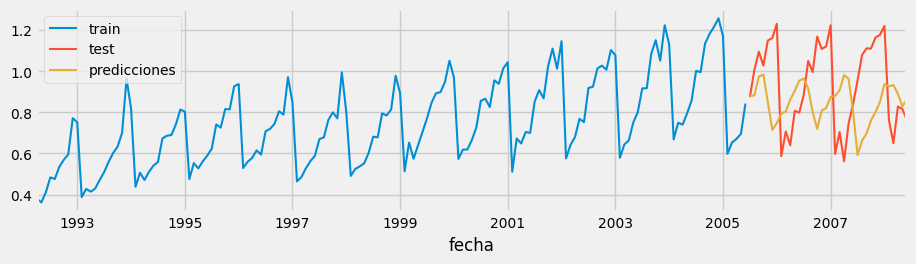

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


In [ ]:
fig, ax = plt.subplots(figsize=(10, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

##**Error de predicción en los datos de test**</font>

Se cuantifica el error que comete el modelo en sus predicciones. En este caso, se emplea como métrica el mean squared error (mse)

In [ ]:
# Error test
# ==============================================================================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.07326833976120374


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Interval predictions for item_1**</font>

In [ ]:
predictions_temp = forecaster.predict_interval(steps=steps)
display(predictions_temp.head(3))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


pred  lower_bound  upper_bound
2005-07-01  0.878756     0.747397     0.949500
2005-08-01  0.882167     0.745884     0.965120
2005-09-01  0.973184     0.749185     1.056049

##  **Cargar y guardar modelos**</font>

Los modelos generados con Skforecast se pueden cargar y guardar usando las librerías Pickle o Joblib**. A continuación se muestra un ejemplo sencillo utilizando. Para facilitar el proceso, dos funciones están disponibles: save_forecaster y load_forecaster. A continuación, se muestra un sencillo ejemplo

#  **Crear forecaster**</font>

In [ ]:
forecaster = ForecasterAutoreg(RandomForestRegressor(random_state=123), lags=3)
forecaster.fit(y=datos['y'])
forecaster.predict(steps=3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2008-07-01    0.751967
2008-08-01    0.826505
2008-09-01    0.879444
Freq: MS, Name: pred, dtype: float64

### **Guardar modelo**

In [ ]:
save_forecaster(forecaster, file_name='forecaster.py', verbose=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### **Cargar modelo**

In [ ]:
forecaster_cargado = load_forecaster('forecaster.py')

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2008-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-12-16 00:16:04 
Last fit date: 2024-12-16 00:16:04 
Skforecast version: 0.13.0 
Python version: 3.10.12 
Forecast

#****Predicciones****</font>

In [ ]:
ffore= forecaster_cargado.predict(steps=10)
ffore

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2008-07-01    0.751967
2008-08-01    0.826505
2008-09-01    0.879444
2008-10-01    0.951809
2008-11-01    0.988960
2008-12-01    0.927266
2009-01-01    0.718773
2009-02-01    0.641496
2009-03-01    0.768129
2009-04-01    0.781793
Freq: MS, Name: pred, dtype: float64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


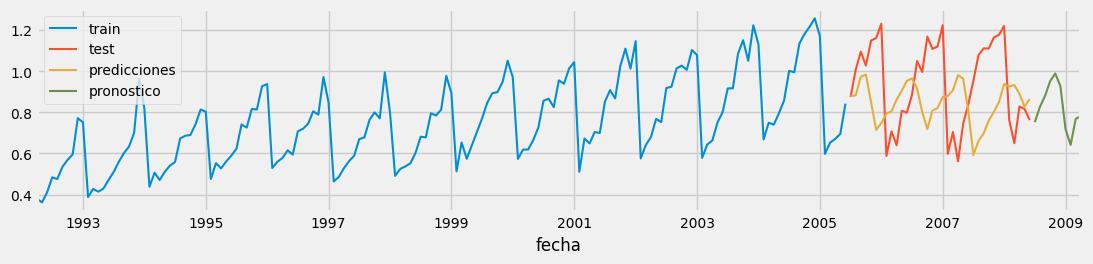

In [ ]:
fig, ax = plt.subplots(figsize=(12, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ffore.plot(ax=ax, label="pronostico")
ax.legend();

#**Ajuste de hiperparámetros (tuning)**

El ForecasterRecursive entrenado ha utilizado una ventana temporal de 6 lags y un modelo Random Forest con los hiperparámetros por defecto. Sin embargo, no hay ninguna razón por la que estos valores sean los más adecuados. La librería Skforecast proporciona varias estrategias de búsqueda para encontrar la mejor combinación de hiperparámetros y lags. En este caso, se utiliza la función grid_search_forecaster, que compara los resultados obtenidos con cada combinación de hiperparámetros y lags, e identifica la mejor.

# **💡 Tip**

El coste computacional del ajuste de hiperparámetros depende en gran medida del enfoque de backtesting elegido para evaluar cada combinación de hiperparámetros. En general, la duración del proceso de ajuste aumenta a medida que crece el número de reentrenamientos implicados en el backtesting.

Para acelerar la fase de prototipado, es muy recomendable adoptar una estrategia en dos pasos. En primer lugar, utilizar refit=False durante la búsqueda inicial para reducir el rango de valores. A continuación, focalizarse en la región de interés identificada y aplicar una estrategia de backtesting que cumpla los requisitos específicos del caso de uso. Para una documentación más detallada visitar: Hyperparameter tuning and lags selection

In [ ]:
# Búsqueda de hiperparámetros: grid search
# ========================================
steps = 36
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 12 # Este valor será remplazado en el grid search
             )

# Valores candidatos de lags
lags_grid = [10, 20]

# Valores candidatos de hiperparámetros del regresor
param_grid = {
      'n_estimators': [100, 250],
      'max_depth': [3, 5, 10]
}

resultados_grid = grid_search_forecaster(
                        forecaster         = forecaster,
                        y                  = datos_train['y'],
                        param_grid         = param_grid,
                        lags_grid          = lags_grid,
                        steps              = steps,
                        refit              = False,
                        metric             = 'mean_squared_error',
                        initial_train_size = int(len(datos_train)*0.5),
                        fixed_train_size   = False,
                        return_best        = True,
                        n_jobs             = 'auto',
                        verbose            = False
                  )

Number of models compared: 12.


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


lags grid:   0%|          | 0/2 [00:00<?, ?it/s]

params grid:   0%|          | 0/6 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20] 
  Parameters: {'max_depth': 3, 'n_estimators': 250}
  Backtesting metric: 0.02177319540541341



In [ ]:
# Resultados de la búsqueda de hiperparámetros
# ============================================
resultados_grid

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


lags  \
7   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
9   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
8   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
6   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
0                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
1                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
4                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
2                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
5                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
3                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   

                                           lags_label  \
7   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
9   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
8   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
6   [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
10  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...   
0                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
1                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
4                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
2                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
5                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   
3                     [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]   

                                    params  mean_squared_error  max_depth  \
7    {'max_depth': 3, 'n_estimators': 250}            0.021773          3   
9    {'max_depth': 5, 'n_estimators': 250}            0.021852          5   
11  {'max_depth': 10, 'n_estimators': 250}            0.021909         10   
8    {'max_depth': 5, 'n_estimators': 100}            0.022530          5   
6    {'max_depth': 3, 'n_estimators': 100}            0.022569          3   
10  {'max_depth': 10, 'n_estimators': 100}            0.023400         10   
0    {'max_depth': 3, 'n_estimators': 100}            0.063144          3   
1    {'max_depth': 3, 'n_estimators': 250}            0.064241          3   
4   {'max_depth': 10, 'n_estimators': 100}            0.066307         10   
2    {'max_depth': 5, 'n_estimators': 100}            0.067151          5   
5   {'max_depth': 10, 'n_estimators': 250}            0.068115         10   
3    {'max_depth': 5, 'n_estimators': 250}            0.068337          5   

    n_estimators  
7            250  
9            250  
11           250  
8            100  
6            100  
10           100  
0            100  
1            250  
4            100  
2            100  
5            250  
3            250

Los mejores resultados se obtienen si se utiliza una ventana temporal de 20 lags y una configuración de Random Forest {'max_depth': 3, 'n_estimators': 250}.

# **Modelo final**

Finalmente, se entrena de nuevo un ForecasterRecursive con la mejor configuración encontrada. Este paso no es necesario si se indica return_best = True en la función grid_search_forecaster.

In [ ]:
# Crear y entrenar forecaster con mejores hiperparámetros
# =======================================================
regressor = RandomForestRegressor(max_depth=3, n_estimators=250, random_state=123)
forecaster = ForecasterAutoreg(
                regressor = regressor,
                lags      = 20
             )
forecaster.fit(y=datos_train['y'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Predicciones
# ============
predicciones = forecaster.predict(steps=steps)
predicciones

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2005-07-01    0.901160
2005-08-01    0.943315
2005-09-01    1.078241
2005-10-01    1.107162
2005-11-01    1.110907
2005-12-01    1.153306
2006-01-01    1.161321
2006-02-01    0.630081
2006-03-01    0.677742
2006-04-01    0.713904
2006-05-01    0.746288
2006-06-01    0.841154
2006-07-01    0.869237
2006-08-01    0.947770
2006-09-01    1.029864
2006-10-01    1.078129
2006-11-01    1.121792
2006-12-01    1.141514
2007-01-01    1.162507
2007-02-01    0.700009
2007-03-01    0.712811
2007-04-01    0.731715
2007-05-01    0.761092
2007-06-01    0.844083
2007-07-01    0.872783
2007-08-01    0.950878
2007-09-01    1.022772
2007-10-01    1.087599
2007-11-01    1.122876
2007-12-01    1.143667
2008-01-01    1.168827
2008-02-01    0.723128
2008-03-01    0.730371
2008-04-01    0.737535
2008-05-01    0.793896
2008-06-01    0.852541
Freq: MS, Name: pred, dtype: float64

# **Gráfico de predicciones vs valores reales**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


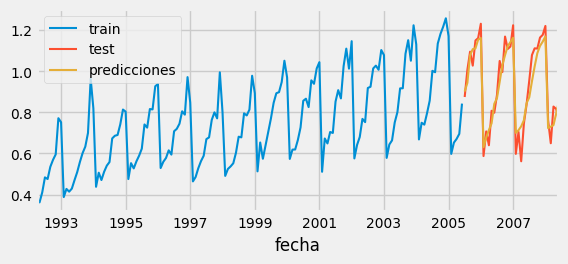

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

# **Error de test**

In [ ]:
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.004356831371529945


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Interval predictions for item_1**

In [ ]:
predictions_temp = forecaster.predict_interval(steps=steps)
display(predictions_temp.head(3))

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


pred  lower_bound  upper_bound
2005-07-01  0.901160     0.839829     0.974762
2005-08-01  0.943315     0.877517     1.009390
2005-09-01  1.078241     0.966841     1.140977

In [ ]:
# Crear forecaster
forecaster = ForecasterAutoreg(RandomForestRegressor(random_state=123), lags=3)
forecaster.fit(y=datos['y'])
forecaster.predict(steps=3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2008-07-01    0.751967
2008-08-01    0.826505
2008-09-01    0.879444
Freq: MS, Name: pred, dtype: float64

In [ ]:
# Guardar modelo
save_forecaster(forecaster, file_name='forecaster.py', verbose=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Cargar modelo
forecaster_cargado = load_forecaster('forecaster.py')

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2008-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-12-16 00:18:14 
Last fit date: 2024-12-16 00:18:14 
Skforecast version: 0.13.0 
Python version: 3.10.12 
Forecast

In [ ]:
# Predicciones
ffore= forecaster_cargado.predict(steps=20)
ffore

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2008-07-01    0.751967
2008-08-01    0.826505
2008-09-01    0.879444
2008-10-01    0.951809
2008-11-01    0.988960
2008-12-01    0.927266
2009-01-01    0.718773
2009-02-01    0.641496
2009-03-01    0.768129
2009-04-01    0.781793
2009-05-01    0.850809
2009-06-01    0.931712
2009-07-01    0.935004
2009-08-01    0.853258
2009-09-01    0.778020
2009-10-01    0.790681
2009-11-01    0.898804
2009-12-01    0.924258
2010-01-01    0.991942
2010-02-01    0.944575
Freq: MS, Name: pred, dtype: float64

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


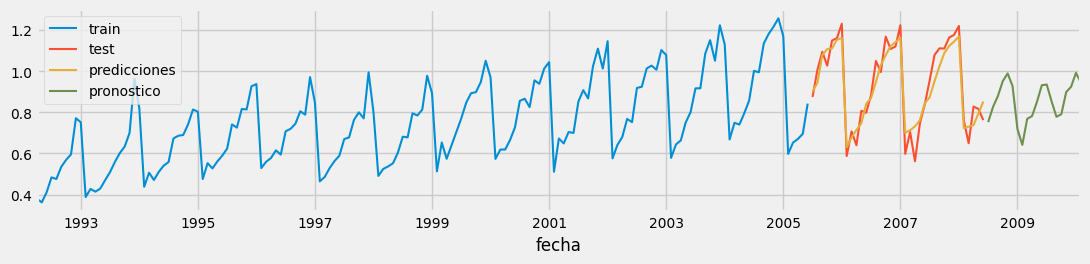

In [ ]:
fig, ax = plt.subplots(figsize=(12, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ffore.plot(ax=ax, label="pronostico")
ax.legend();

#**Backtesting**

Para obtener una estimación robusta de la capacidad predictiva del modelo, se lleva a cabo un proceso de backtesting. El backtesting consiste en evaluar el comportamiento de un modelo predictivo al aplicarlo de forma retrospectiva sobre datos históricos. Por lo tanto, es una estrategia de validación que permite cuantificar la capacidad predictiva de un modelo.

# **✎ Note**

Para garantizar una evaluación precisa de su modelo y ganar confianza en su rendimiento predictivo con nuevos datos, es fundamental emplear una estrategia de backtesting adecuada. Factores como las características del caso de uso, los recursos informáticos disponibles y los intervalos de tiempo entre predicciones deben tenerse en cuenta para determinar qué estrategia utilizar.

En términos generales, cuanto más se parezca el proceso de backtesting al escenario real en el que se utilizará el modelo, más fiable será la métrica estimada. Para obtener más consejos sobre estrategias de backtesting, consultar Which strategy should I use?.
# **Backtesting con reentrenamiento**

El modelo se entrena cada vez antes de realizar las predicciones, de esta forma, se incorpora toda la información disponible hasta el momento. Se trata de una adaptación del proceso de cross-validation en el que, en lugar de hacer un reparto aleatorio de las observaciones, el conjunto de entrenamiento se incrementa de manera secuencial, manteniendo el orden temporal de los datos.

##**Backtesting con reentrenamiento cada n periodos (intermitente)**

El modelo se reentrena de forma intermitente cada  n
  periodos de predicción.

#**💡 Tip**

Esta estrategia suele lograr un buen equilibrio entre el coste computacional del reentrenamiento y evitar la degradación del modelo.
##**Backtesting sin reentrenamiento**

Con esta estrategia, el modelo se entrena una única vez con un conjunto inicial y se realizan las predicciones de forma secuencial sin actualizar el modelo y siguiendo el orden temporal de los datos. Esta estrategia tiene la ventaja de ser mucho más rápida puesto que el modelo solo se entrena una vez. La desventaja es que el modelo no incorpora la última información disponible por lo que puede perder capacidad predictiva con el tiempo.

##**Skip folds**

Todos las estrategias de backtesting mencionadas pueden combinarse con la opción de saltarse un cierto número de folds mediante el argumento skip_folds. Dado que el modelo predice menos puntos en el tiempo, el coste computacional se reduce y el proceso de backtesting es más rápido. Esto es particularmente útil cuando se busca una estimación aproximada del rendimiento del modelo, pero no se requiere una evaluación exacta, por ejemplo, al buscar hiperparámetros. Si skip_folds es un entero, se devolverá cada 'skip_folds'-ésimo. Si skip_folds es una lista, se saltarán los folds de la lista. Por ejemplo, si skip_folds = 3, y hay 10 folds, los folds devueltos serán [0, 3, 6, 9]. Si skip_folds es una lista [1, 2, 3], los folds devueltos serán [0, 4, 5, 6, 7, 8, 9].




La librería skforecast dispone de múltiples estrategias de backtesting mencionadas. Independientemente de cuál se utilice, es importante no incluir los datos de test en el proceso de búsqueda para no caer en problemas de overfitting.

Para este ejemplo, se sigue una estrategia de backtesting con reentrenamiento. Internamente, el proceso seguido por la función es el siguiente:

En la primera iteración, el modelo se entrena con las observaciones seleccionadas para el entrenamiento inicial (en este caso, 87). Después, se predicen las siguientes 36 observaciones.

En la segunda iteración, se reentrena el modelo extendiendo el conjunto de entrenamiento inicial con 36 observaciones (87 + 36), y se predicen las siguientes 36.

Este proceso se repite hasta que se utilizan todas las observaciones disponibles y se calcula la métrica de validación con todas las predicciones acumuladas. Siguiendo esta estrategia, el conjunto de entrenamiento aumenta en cada iteración con tantas observaciones como steps se estén prediciendo.

In [ ]:
# Backtesting
# ============
steps = 36
n_backtesting = 36*3 # Se separan para el backtest los últimos 9 años
metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = datos['y'],
                                    initial_train_size = len(datos) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = 'mean_squared_error',
                                    verbose            = True
                                 )
metrica

Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/3 [00:00<?, ?it/s]

mean_squared_error
0            0.053099

# **Gráfico de predicciones de backtest vs valores reales**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


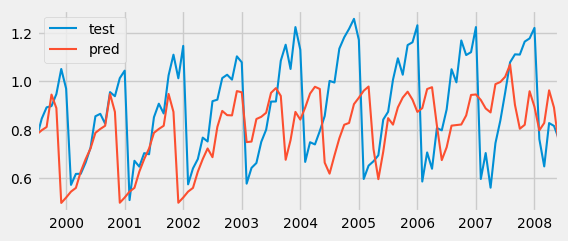

In [ ]:
fig, ax = plt.subplots(figsize=(6, 2.5))
datos.loc[predicciones_backtest.index, 'y'].plot(ax=ax, label='test')
predicciones_backtest.plot(ax=ax, label='predicciones')
ax.legend();

#**Explicabilidad del modelo (importancia de los predictores)**

Debido a la naturaleza compleja de muchos de los actuales modelos de machine learning, a menudo funcionan como cajas negras, lo que dificulta entender por qué han hecho una predicción u otra. Las técnicas de explicabilidad pretenden desmitificar estos modelos, proporcionando información sobre su funcionamiento interno y ayudando a generar confianza, mejorar la transparencia y cumplir los requisitos normativos en diversos ámbitos. Mejorar la explicabilidad de los modelos no sólo ayuda a comprender su comportamiento, sino también a identificar sesgos, mejorar su rendimiento y permitir a las partes interesadas tomar decisiones más informadas basadas en los conocimientos del machine learning.

Skforecast es compatible con algunos de los métodos de explicabilidad más populares: model-specific feature importances, SHAP values, and partial dependence plots.
#**Importancia model-specific**

In [ ]:
# Importancia predictores
# =======================
importancia = forecaster.get_feature_importances()
importancia.head(10)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


feature  importance
0   lag_1    0.684979
1   lag_2    0.204103
2   lag_3    0.110918

# **Definir parámetros de backtesting**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/4 [00:00<?, ?it/s]

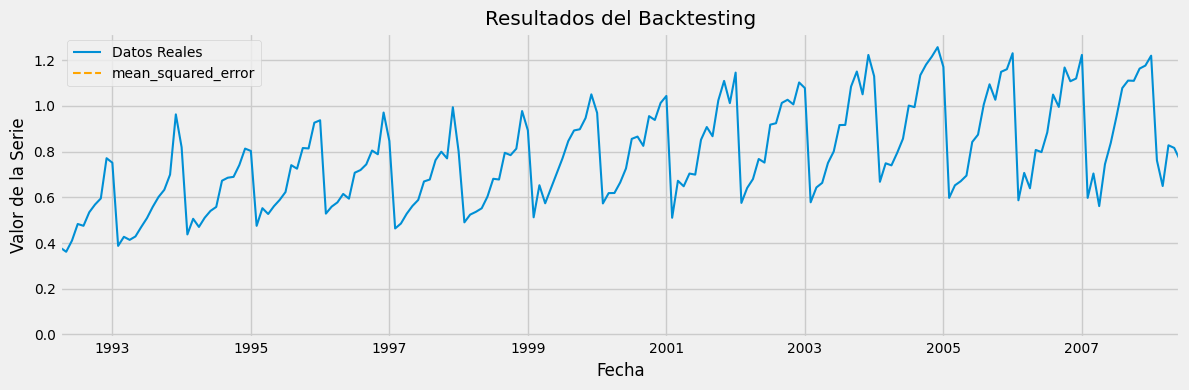

In [ ]:
from skforecast.model_selection import backtesting_forecaster

# Definir el tamaño del conjunto de entrenamiento inicial
initial_train_size = int(len(datos) * 0.8)  # Ajusta este valor según tu caso

# Realizar backtesting (asegúrate de ajustar los parámetros según tu modelo y forecaster)
backtest_results, _ = backtesting_forecaster(
    forecaster=forecaster,  # Asegúrate de que 'forecaster' esté definido
    y=datos['y'],
    initial_train_size=initial_train_size,
    steps=10,  # Número de pasos de predicción en cada iteración
    refit=True,  # Vuelve a ajustar el modelo en cada iteración
    metric='mean_squared_error',  # Métrica de evaluación
    verbose=False
)

# Ahora puedes ejecutar el código de visualización:
import matplotlib.pyplot as plt

# Asegurarse de que el índice de backtest_results es de tipo DatetimeIndex
backtest_results.index = pd.date_range(
    start=datos.index[initial_train_size],  # Ajusta el inicio al índice correcto
    periods=len(backtest_results),
    freq=datos.index.freq  # Usa la misma frecuencia de datos
)

# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 4))

# Graficar la serie temporal completa
datos['y'].plot(ax=ax, label='Datos Reales')

# Graficar las predicciones obtenidas en el proceso de backtesting
backtest_results.plot(ax=ax, label='Predicciones en Backtesting', color='orange', linestyle='--')

# Ajustar el gráfico con leyenda y etiquetas
ax.legend()
plt.title("Resultados del Backtesting")
plt.xlabel("Fecha")
plt.ylabel("Valor de la Serie")
plt.tight_layout()  # Para un ajuste perfecto de los elementos gráficos
plt.show()


## **1. Cálculo del error en el conjunto de prueba (Test Error)**

In [ ]:
from sklearn.metrics import mean_squared_error

error_mse = mean_squared_error(
    y_true=datos_test['y'],
    y_pred=predicciones
)
print(f"Error de test (MSE): {error_mse}")


Error de test (MSE): 0.004356831371529945


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **2. Intervalos de predicción para item_1**

In [ ]:
interval_predictions = forecaster.predict_interval(steps=steps)
display(interval_predictions.head(3))  # Muestra las primeras filas


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


pred  lower_bound  upper_bound
2008-07-01  0.751967     0.612551     0.846395
2008-08-01  0.826505     0.649428     0.919156
2008-09-01  0.879444     0.680752     0.994303

## **3. Creación del Backtest**

In [ ]:
from skforecast.model_selection import backtesting_forecaster

# Parámetros de backtesting (ajusta según tus necesidades)
window_size = 36  # Ejemplo para el tamaño de ventana
metric, backtest_predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=datos['y'],
    initial_train_size=len(datos_train),
    steps=steps,
    metric='mean_squared_error',
    verbose=True
)
print(f"Error del backtest (MSE): {metric}")


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Information of backtesting process
----------------------------------
Number of observations used for initial training: 159
Number of observations used for backtesting: 36
    Number of folds: 1
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/1 [00:00<?, ?it/s]

Error del backtest (MSE):    mean_squared_error
0             0.04947


## **4. Guardar el Modelo**


In [ ]:
from skforecast.utils import save_forecaster

save_forecaster(forecaster, file_name='forecaster.py', verbose=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **5. Cargar el Modelo**


In [ ]:
from skforecast.utils import load_forecaster

forecaster_cargado = load_forecaster('forecaster.py')


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2008-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-12-16 00:18:14 
Last fit date: 2024-12-16 00:18:14 
Skforecast version: 0.13.0 
Python version: 3.10.12 
Forecast

## **6. Generación de Predicciones**

In [ ]:
predicciones_nuevas = forecaster_cargado.predict(steps=10)
predicciones_nuevas


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2008-07-01    0.751967
2008-08-01    0.826505
2008-09-01    0.879444
2008-10-01    0.951809
2008-11-01    0.988960
2008-12-01    0.927266
2009-01-01    0.718773
2009-02-01    0.641496
2009-03-01    0.768129
2009-04-01    0.781793
Freq: MS, Name: pred, dtype: float64

## **7. Gráfico de Predicción (Entrenamiento, Prueba, Predicciones y Pronóstico)**

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


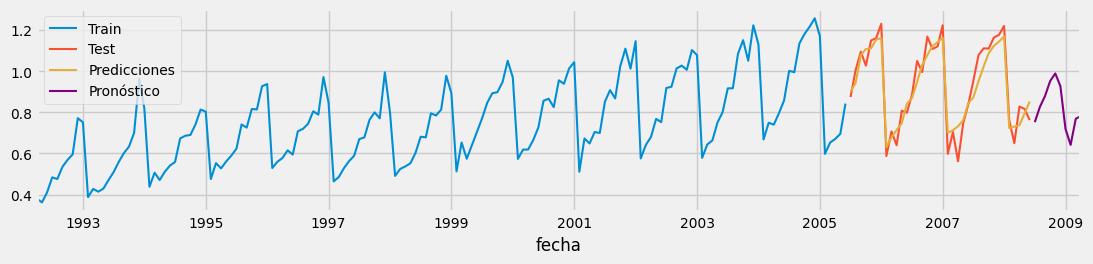

In [ ]:
# Crear las predicciones a partir del último punto en los datos de prueba
steps_pronostico = 10  # Ajusta según la cantidad de pasos deseados
inicio_pronostico = datos_test.index[-1] + pd.DateOffset(months=1)  # Comienza un mes después del último dato

# Generar el pronóstico
predicciones_nuevas = forecaster_cargado.predict(steps=steps_pronostico)
predicciones_nuevas.index = pd.date_range(start=inicio_pronostico, periods=steps_pronostico, freq=datos.index.freq)

# Gráfico ajustado para que el pronóstico se ubique correctamente en el tiempo
fig, ax = plt.subplots(figsize=(12, 2.5))
datos_train['y'].plot(ax=ax, label='Train')
datos_test['y'].plot(ax=ax, label='Test')
predicciones.plot(ax=ax, label='Predicciones')
predicciones_nuevas.plot(ax=ax, label='Pronóstico', color='purple')
ax.legend()
plt.show()


# **⚠ Warning**

get_feature_importances() solo devuelve valores si el regresor utilizado dentro del forecaster tiene el atributo coef_ o feature_importances_.
# **Shap values**

Los valores SHAP (SHapley Additive exPlanations) son un método muy utilizado para explicar los modelos de machine learning, ya que ayudan a comprender cómo influyen las variables y los valores en las predicciones de forma visual y cuantitativa.

Se puede obtener un análisis SHAP a partir de modelos skforecast con sólo dos elementos:

El regresor interno del forecaster.

Las matrices de entrenamiento creadas a partir de la serie temporal y variables exógenas, utilizadas para ajustar el pronosticador.

Aprovechando estos dos componentes, los usuarios pueden crear explicaciones interpretables para sus modelos de skforecast. Estas explicaciones pueden utilizarse para verificar la fiabilidad del modelo, identificar los factores más significativos que contribuyen a las predicciones y comprender mejor la relación subyacente entre las variables de entrada y la variable objetivo.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


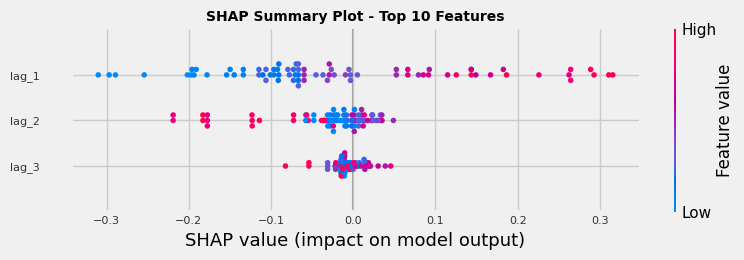

In [ ]:
from sklearn.utils import resample

# Crear matrices de entrenamiento
X_train, y_train = forecaster.create_train_X_y(y=datos_train['y'])

# Crear SHAP explainer para modelos de árboles
explainer = shap.TreeExplainer(forecaster.regressor)

# Selección de una muestra aleatoria del 50% de X_train para cálculo rápido
X_train_sample = resample(X_train, n_samples=int(len(X_train)*0.5), random_state=785412)

# Calcular los valores SHAP
shap_values = explainer.shap_values(X_train_sample)

# Configuración de la visualización SHAP
shap.initjs()
fig, ax = plt.subplots(figsize=(8, 4))  # Ajuste del tamaño de la figura
shap.summary_plot(shap_values, X_train_sample, max_display=10, show=False)

# Personalización del título y tamaño de etiquetas
ax.set_title("SHAP Summary Plot - Top 10 Features", fontsize=10, weight='bold')
ax.tick_params(labelsize=8)
plt.tight_layout()  # Asegura que los elementos no se superpongan
plt.show()


# **Note**

La librería Shap cuenta con varios *Explainers*, cada uno diseñado para un tipo de modelo diferente. El shap.TreeExplainer explainer se utiliza para modelos basados en árboles, como el RandomForestRegressor utilizado en este ejemplo. Para más información, consultar la documentación de SHAP..

#**Forecasting con variables exógenas**

En el ejemplo anterior, se han utilizado como predictores únicamente lags de la propia variable predicha. En ciertos escenarios, es posible disponer de información sobre otras variables, cuyo valor a futuro se conoce, y pueden servir como predictoreres adicionales en el modelo.

Siguiendo con el ejemplo anterior, se simula una nueva variable cuyo comportamiento está correlacionado con la serie temporal modelada y que, por lo tanto, se quiere incorporar como predictor. Esto mísmo es aplicable a múltiples variables exógenas.

## **Descarga de datos**

In [7]:
# Cargar los datos desde el archivo Excel
import pandas as pd

datos = pd.read_excel('/content/datos_ingenieria.xlsx')

# Convertir la columna 'fecha' al tipo datetime para trabajar con series temporales
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')

# Establecer la columna 'fecha' como índice del DataFrame
datos.set_index('fecha', inplace=True)

# Asegurar que los datos tengan una frecuencia mensual (MS: Month Start)
datos = datos.asfreq('MS')

# Mostrar las primeras filas para verificar los datos cargados
datos.head()


temperatura      presion  velocviento   humendad  produc_energia
fecha                                                                       
1910-01-01    17.490802  1015.791540     3.285316  48.826402      454.477965
1910-02-01    13.410482  1022.876191     6.234441  44.349338      435.926612
1910-03-01    16.506607  1010.863381    18.945667  70.930569      934.331090
1910-04-01    12.391885  1017.389377    16.057069  86.861424      956.263008
1910-05-01    26.148803  1023.517370     1.341530  51.038481      308.752387

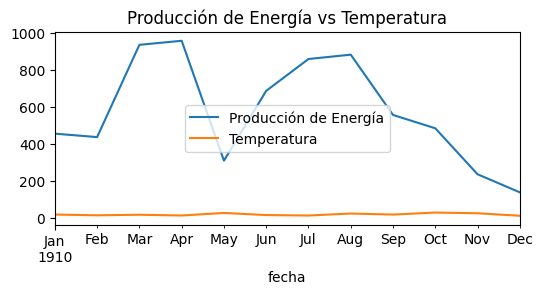

In [8]:
import matplotlib.pyplot as plt
import pandas as pd

# Cargar los datos desde el archivo Excel
datos = pd.read_excel('/content/datos_ingenieria.xlsx')

# Convertir la columna 'fecha' al tipo datetime para trabajar con series temporales
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')

# Establecer la columna 'fecha' como índice del DataFrame
datos.set_index('fecha', inplace=True)

# Asegurar que los datos tengan una frecuencia mensual (MS: Month Start)
datos = datos.asfreq('MS')

# Ordenar los datos por fecha (índice)
datos = datos.sort_index()

# Graficar las variables
fig, ax = plt.subplots(figsize=(6, 2.5))
datos['produc_energia'].plot(ax=ax, label='Producción de Energía')  # Suponiendo que 'produc_energia' es la variable dependiente
datos['temperatura'].plot(ax=ax, label='Temperatura')  # Suponiendo que 'temperatura' es una variable exógena
ax.legend()
plt.title("Producción de Energía vs Temperatura")
plt.show()


In [ ]:
# Separación datos train-test
# ===========================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]
print(
    f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})"
)
print(
    f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})"
)

Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Crear y entrenar forecaster
# ==========================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags      = 8
             )
forecaster.fit(y=datos_train['y'], exog=datos_train['exog_1'])
forecaster

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Exogenous variables names: ['exog_1'] 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-12-16 00:19:09 
Last fit date: 2024-12-16 00:19:10 
Skforecast version: 0.13.0 
Python version: 3.

Si el ForecasterRecursive se entrena con una variable exógena, hay que pasarle el valor de esta variable al predict(). Por lo tanto, solo es aplicable a escenarios en los que se dispone de información a futuro de la variable exógena.

In [ ]:
# Predicciones
# ============
predicciones = forecaster.predict(steps=steps, exog=datos_test['exog_1'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


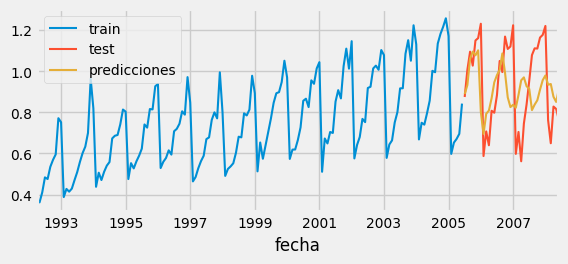

In [ ]:
# Gráfico predicciones vs valores reales
# ======================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

## **1. Error de Prueba**


In [ ]:
from sklearn.metrics import mean_squared_error

error_mse = mean_squared_error(
    y_true=datos_test['y'],
    y_pred=predicciones
)
print(f"Error de test (MSE): {error_mse}")


Error de test (MSE): 0.03989087922533575


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **2. Intervalo de Predicciones para item_1**

In [ ]:
#interval_predictions = forecaster.predict_interval(steps=steps)
#display(interval_predictions.head(3))  # Muestra las primeras filas


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **3. Creación del Backtest**

In [ ]:
from skforecast.model_selection import backtesting_forecaster

window_size = 36  # Ajusta según tus necesidades
metric, backtest_predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=datos['y'],
    initial_train_size=len(datos_train),
    steps=steps,
    metric='mean_squared_error',
    verbose=True
)
print(f"Error del backtest (MSE): {metric}")


Information of backtesting process
----------------------------------
Number of observations used for initial training: 159
Number of observations used for backtesting: 36
    Number of folds: 1
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/1 [00:00<?, ?it/s]

Error del backtest (MSE):    mean_squared_error
0             0.04369


## **4. Guardar el Modelo**

In [ ]:
from skforecast.utils import save_forecaster

save_forecaster(forecaster, file_name='forecaster.py', verbose=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **5. Cargar el Modelo**

In [ ]:
from skforecast.utils import load_forecaster

forecaster_cargado = load_forecaster('forecaster.py')


ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: None 
Transformer for exog: None 
Window size: 8 
Weight function included: False 
Differentiation order: None 
Exogenous included: True 
Exogenous variables names: ['exog_1'] 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-12-16 00:19:09 
Last fit date: 2024-12-16 00:19:10 
Skforecast version: 0.13.0 
Python version: 3.

## **6. Predicciones con el Modelo Cargado**

In [ ]:
#predicciones_nuevas = forecaster_cargado.predict(steps=10)
#predicciones_nuevas


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **7. Gráfico de Predicción**

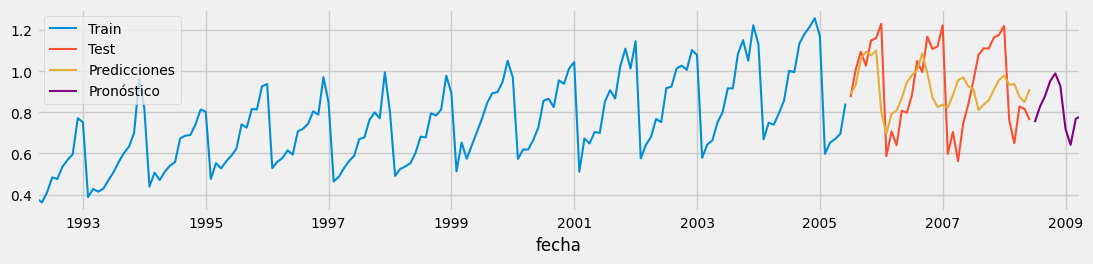

In [ ]:
# Crear las predicciones futuras a partir del último punto en los datos de prueba
steps_pronostico = 10  # Cambia según los pasos deseados
inicio_pronostico = datos_test.index[-1] + pd.DateOffset(months=1)  # Comienza un mes después del último dato

# Generar el pronóstico
predicciones_nuevas.index = pd.date_range(start=inicio_pronostico, periods=steps_pronostico, freq=datos.index.freq)

# Gráfico con predicción y pronóstico
fig, ax = plt.subplots(figsize=(12, 2.5))
datos_train['y'].plot(ax=ax, label='Train')
datos_test['y'].plot(ax=ax, label='Test')
predicciones.plot(ax=ax, label='Predicciones')
predicciones_nuevas.plot(ax=ax, label='Pronóstico', color='purple')
ax.legend()
plt.show()


#**Predictores custom y window features**

En determinados escenarios, puede ser interesante incorporar otras características de la serie temporal además de los lags, por ejemplo, la media movil de los últimos n valores puede servir para capturar la tendencia de la serie.

La clase ForecasterAutoregCustom se comporta de forma muy similar a la clase ForecasterAutoreg vista en los apartados anteriores pero con la diferencia de que, es el usuario, quien define la función empleada para crear los predictores. Esta función recibe una serie temporal como entrada (un ndarray NumPy) y genere otro ndarray NumPy que contenga los predictores. Los parámetros del Forecaster utilizados para especificar esta función son fun_predictors, window_size y name_predictors (opcional).

Se repite el primer ejemplo del documento, predecir los últimos 36 meses de la serie temporal, pero esta vez, utilizando como predictores los 10 primeros lags y la media móvil de los últimos 20 meses.

# **⚠ Warning**

Al crear el forecaster, el argumento window_size debe ser igual a la ventana que utiliza la función que crea los predictores. En este caso 20.

In [ ]:
# Descarga de datos
# =================
datos = fetch_dataset(name='h2o_exog', raw=True, verbose=False)
# Preparación del dato
# ======================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()

# Separación datos train-test
# ========================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Se crea y entrena un ForecasterAutoregCustom a partir de un regresor RandomForestRegressor. Para crear los predictores, se emplea la función create_predictors() que calcula los primeros 10 lags y la media móvil de los últimos 20 valores.

In [ ]:
# Función para calcular los predictores a partir de la serie temporal
# ====================================================================
def custom_predictors(y):
    '''
    Crea los 10 primeros lags de la serie temporal
    Crea la media de los últimos 20 valores de la serie temporal
    '''

    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])

    return predictors

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Al crear el forecaster, el argumento window_size debe ser igual a la ventana que utiliza la función que crea los predictores. En este caso 20.

In [ ]:
# Crear y entrenar forecaster
# ===========================
forecaster = ForecasterAutoregCustom(
                regressor      = RandomForestRegressor(random_state=123),
                fun_predictors = custom_predictors,
                window_size    = 20
             )
forecaster.fit(y=datos_train['y'])
forecaster

ForecasterAutoregCustom 
Regressor: RandomForestRegressor(random_state=123) 
Predictors created with function: custom_predictors 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-12-16 00:19:11 
Last fit date: 202

Se puede acceder al código de la función utilizada para crear lo predictores.

In [ ]:
# Código de la función custom que calcula los predictores
# ======================================================
print(forecaster.source_code_fun_predictors)

def custom_predictors(y):
    '''
    Crea los 10 primeros lags de la serie temporal
    Crea la media de los últimos 20 valores de la serie temporal
    '''

    lags = y[-1:-11:-1]
    mean = np.mean(y[-20:])
    predictors = np.hstack([lags, mean])

    return predictors



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Mediante el método create_train_X_y, se puede acceder a las matrices que se crean internamente en el proceso de entrenamiento del forecaster.

In [ ]:
# Matrices de entrenamiento
# ==========================
X_train, y_train = forecaster.create_train_X_y(y=datos_train['y'])
display(X_train.head(5))
display(y_train.head(5))

custom_predictor_0  custom_predictor_1  custom_predictor_2  \
fecha                                                                    
1993-12-01            0.699605            0.632947            0.601514   
1994-01-01            0.963081            0.699605            0.632947   
1994-02-01            0.819325            0.963081            0.699605   
1994-03-01            0.437670            0.819325            0.963081   
1994-04-01            0.506121            0.437670            0.819325   

            custom_predictor_3  custom_predictor_4  custom_predictor_5  \
fecha                                                                    
1993-12-01            0.558443            0.509210            0.470126   
1994-01-01            0.601514            0.558443            0.509210   
1994-02-01            0.632947            0.601514            0.558443   
1994-03-01            0.699605            0.632947            0.601514   
1994-04-01            0.963081            0.699605            0.632947   

            custom_predictor_6  custom_predictor_7  custom_predictor_8  \
fecha                                                                    
1993-12-01            0.428859            0.413890            0.427283   
1994-01-01            0.470126            0.428859            0.413890   
1994-02-01            0.509210            0.470126            0.428859   
1994-03-01            0.558443            0.509210            0.470126   
1994-04-01            0.601514            0.558443            0.509210   

            custom_predictor_9  custom_predictor_10  
fecha                                                
1993-12-01            0.387554             0.523089  
1994-01-01            0.427283             0.552253  
1994-02-01            0.413890             0.575129  
1994-03-01            0.428859             0.576486  
1994-04-01            0.470126             0.577622

fecha
1993-12-01    0.963081
1994-01-01    0.819325
1994-02-01    0.437670
1994-03-01    0.506121
1994-04-01    0.470491
Freq: MS, Name: y, dtype: float64

In [ ]:
# Predicciones
# ============
steps = 36
predicciones = forecaster.predict(steps=steps)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


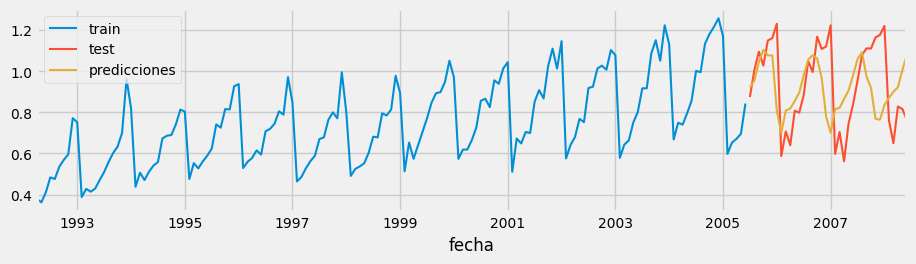

In [ ]:
# Gráfico predicciones vs valores reales
# ======================================
fig, ax = plt.subplots(figsize=(10, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error test
# ==========
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones
            )
print(f"Error de test (mse): {error_mse}")

Error de test (mse): 0.046232546768232


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Paso 1: Definir la Función de Predictores Personalizados**

In [ ]:
import numpy as np
import pandas as pd
from skforecast.ForecasterAutoregCustom import ForecasterAutoregCustom
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Función de predictores personalizados
def custom_predictors(y):
    """
    Genera los predictores: los primeros 10 lags y la media móvil de los últimos 20 meses.
    """
    lags = y[-10:]  # Últimos 10 valores como lags
    moving_avg = y[-20:].mean()  # Media móvil de los últimos 20 valores
    return np.hstack([lags, moving_avg])  # Combina lags y media móvil en un solo array

# Crear el ForecasterAutoregCustom con la función de predictores personalizados
forecaster = ForecasterAutoregCustom(
    regressor=RandomForestRegressor(random_state=123),
    fun_predictors=custom_predictors,
    window_size=20  # Tamaño de la ventana para la media móvil
)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Paso 2: Entrenar el Modelo**

In [ ]:
# Entrenar el forecaster con los datos de entrenamiento
forecaster.fit(y=datos_train['y'])


## **Paso 3: Cálculo del Error de Prueba**


In [ ]:
# Generar predicciones
predicciones = forecaster.predict(steps=36)

# Calcular el error MSE
error_mse = mean_squared_error(y_true=datos_test['y'], y_pred=predicciones)
print(f"Error de test (MSE): {error_mse}")


Error de test (MSE): 0.04956036412011534


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Paso 4: Intervalos de Predicción para item_1**

In [ ]:
# Intervalo de predicción para 'item_1'
#interval_predictions = forecaster.predict_interval(steps=36, alpha=0.05)
#display(interval_predictions.head(3))


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Paso 5: Creación del Backtest**

In [ ]:
from skforecast.model_selection import backtesting_forecaster

# Backtesting del modelo
metric, backtest_predictions = backtesting_forecaster(
    forecaster=forecaster,
    y=datos['y'],
    initial_train_size=len(datos_train),
    steps=36,
    metric='mean_squared_error',
    verbose=True
)
print(f"Error del backtest (MSE): {metric}")


Information of backtesting process
----------------------------------
Number of observations used for initial training: 159
Number of observations used for backtesting: 36
    Number of folds: 1
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/1 [00:00<?, ?it/s]

Error del backtest (MSE):    mean_squared_error
0             0.04956


## **Paso 6: Guardar el Modelo**


In [ ]:
from skforecast.utils import save_forecaster

save_forecaster(forecaster, file_name='forecaster_custom.py', verbose=False)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


## **Paso 7: Cargar el Modelo**


In [ ]:
from skforecast.utils import load_forecaster

forecaster_cargado = load_forecaster('forecaster_custom.py')


ForecasterAutoregCustom 
Regressor: RandomForestRegressor(random_state=123) 
Predictors created with function: custom_predictors 
Transformer for y: None 
Transformer for exog: None 
Window size: 20 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Type of exogenous variable: None 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2005-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-12-16 00:19:12 
Last fit date: 202

## **Paso 8: Generación de Predicciones**


In [ ]:
# Predicciones a futuro (pronóstico)
predicciones_nuevas = forecaster_cargado.predict(steps=10)
predicciones_nuevas


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2005-07-01    0.926873
2005-08-01    0.953160
2005-09-01    1.049167
2005-10-01    1.106173
2005-11-01    1.076378
2005-12-01    1.082558
2006-01-01    0.808717
2006-02-01    0.703374
2006-03-01    0.799415
2006-04-01    0.811326
Freq: MS, Name: pred, dtype: float64

## **Paso 9: Gráfica de Predicción (Entrenamiento, Prueba, Predicciones y Pronóstico)**


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


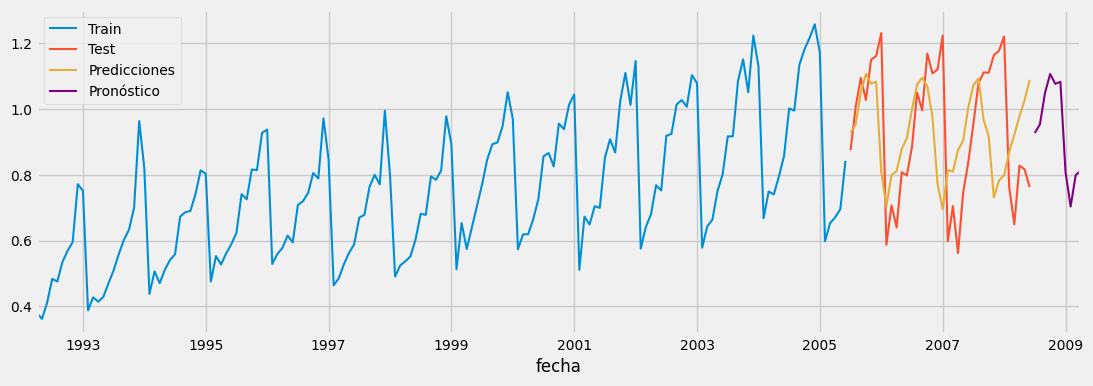

In [ ]:
# Ajustar el índice de predicciones futuras
inicio_pronostico = datos_test.index[-1] + pd.DateOffset(months=1)
predicciones_nuevas.index = pd.date_range(start=inicio_pronostico, periods=10, freq=datos.index.freq)

# Graficar los resultados
fig, ax = plt.subplots(figsize=(12, 4))
datos_train['y'].plot(ax=ax, label='Train')
datos_test['y'].plot(ax=ax, label='Test')
predicciones.plot(ax=ax, label='Predicciones')
predicciones_nuevas.plot(ax=ax, label='Pronóstico', color='purple')
ax.legend()
plt.show()


#**Direct multi-step forecasting**

Para conseguir predicciones a varios steps a futuro, los modelos ForecasterAutoreg y ForecasterAutoregCustom siguen una estrategia de predicción recursiva en la que, cada nueva predicción, se basa en la predicción anterior. Una alternativa es entrenar un modelo para cada uno de los steps que se desea predecir. Esta estrategia, normalmente conocida como direct multi-step forecasting, es computacionalmente más costosa que la recursiva puesto que requiere entrenar varios modelos. Sin embargo, en algunos escenarios, consigue mejores resultados. Este tipo de modelos pueden obtenerse con la clase ForecasterAutoregDirect y pueden incluir también una o múltiples variables exógenas.

# **⚠ Warning**

Los `ForecasterAutoregDirect` pueden requerir tiempos de entrenamiento muy elevados, ya que se ajusta un modelo por cada step.

# **ForecasterDirect**

A diferencia de cuando se utiliza ForecasterRecursive, en los modelos de tipo ForecasterDirect hay que indicar, en el momento de su creación, el número de steps que se quieren predecir. No es posible predecir steps más allá del valor definido en su creación.

Para este ejemplo, se utiliza como regresor un modelo lineal con penalización de Ridge. Estos modelos requieren que los predictores se estandaricen, por lo que se combina con un StandardScaler. Para una documentación más detallada de como incluir transformers y pipelines, visitar: skforecast with transformers and pipeline.

In [ ]:
# Crear forecaster
# ================
forecaster = ForecasterAutoregDirect(
                regressor     = Ridge(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8
             )

forecaster

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


ForecasterAutoregDirect 
Regressor: Ridge(random_state=123) 
Lags: [1 2 3 4 5 6 7 8] 
Transformer for y: StandardScaler() 
Transformer for exog: None 
Weight function included: False 
Window size: 8 
Maximum steps predicted: 36 
Exogenous included: False 
Exogenous variables names: None 
Training range: None 
Training index type: None 
Training index frequency: None 
Regressor parameters: {'alpha': 1.0, 'copy_X': True, 'fit_intercept': True, 'max_iter': None, 'positive': False, 'random_state': 123, 'solver': 'auto', 'tol': 0.0001} 
fit_kwargs: {} 
Creation date: 2024-12-16 00:19:14 
Last fit date: None 
Skforecast version: 0.13.0 
Python version: 3.10.12 
Forecaster id: None 

In [ ]:
# Búsqueda de hiperparámetros
# =============================
from skforecast.exceptions import LongTrainingWarning
warnings.simplefilter('ignore', category=LongTrainingWarning)

forecaster = ForecasterAutoregDirect(
                regressor     = Ridge(random_state=123),
                transformer_y = StandardScaler(),
                steps         = 36,
                lags          = 8 # Este valor será remplazado en el grid search
             )
param_grid = {'alpha': np.logspace(-5, 5, 10)}
lags_grid = [5, 12, 20]

resultados_grid = grid_search_forecaster(
                    forecaster         = forecaster,
                    y                  = datos_train['y'],
                    param_grid         = param_grid,
                    lags_grid          = lags_grid,
                    steps              = 36,
                    refit              = False,
                    metric             = 'mean_squared_error',
                    initial_train_size = int(len(datos_train)*0.5),
                    fixed_train_size   = False,
                    return_best        = True,
                    n_jobs             = 'auto',
                    verbose            = False
                )

Number of models compared: 30.


lags grid:   0%|          | 0/3 [00:00<?, ?it/s]

params grid:   0%|          | 0/10 [00:00<?, ?it/s]

`Forecaster` refitted using the best-found lags and parameters, and the whole data set: 
  Lags: [ 1  2  3  4  5  6  7  8  9 10 11 12] 
  Parameters: {'alpha': 0.2782559402207126}
  Backtesting metric: 0.02741394826520458



In [ ]:
# Resultados de la búsqueda de hiperparámetros
# ===========================================
resultados_grid.head()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


lags  \
14  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   
15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   
13  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   
12  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   

                                 lags_label                            params  \
14  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]     {'alpha': 0.2782559402207126}   
15  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]      {'alpha': 3.593813663804626}   
13  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]   {'alpha': 0.021544346900318846}   
12  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  {'alpha': 0.0016681005372000592}   
11  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]  {'alpha': 0.0001291549665014884}   

    mean_squared_error     alpha  
14            0.027414  0.278256  
15            0.027435  3.593814  
13            0.027484  0.021544  
12            0.027490  0.001668  
11            0.027491  0.000129

Los mejores resultados se obtienen utilizando una ventana temporal de 12 lags y una configuración de Lasso {'alpha': 0.2782559}.

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


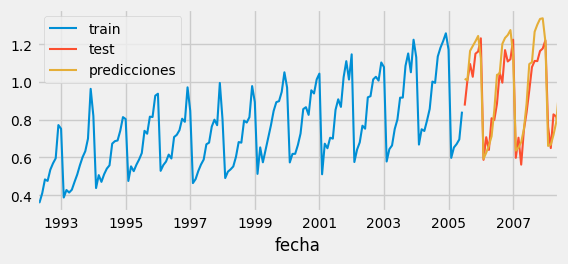

In [ ]:
# Predicciones
# ============
predicciones = forecaster.predict()

# Gráfico predicciones vs valores reales
# ============
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_train['y'].plot(ax=ax, label='train')
datos_test['y'].plot(ax=ax, label='test')
predicciones.plot(ax=ax, label='predicciones')
ax.legend();

In [ ]:
# Error test
# ===========
error_mse = mean_squared_error(y_true = datos_test['y'], y_pred = predicciones)
print(f"Error de test (mse) {error_mse}")

Error de test (mse) 0.011792965469623131


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


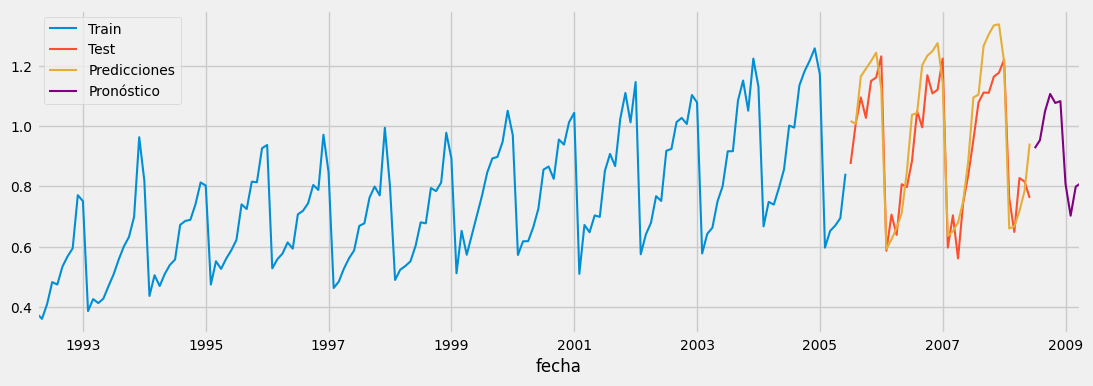

In [ ]:
# Ajustar el índice de predicciones futuras
inicio_pronostico = datos_test.index[-1] + pd.DateOffset(months=1)
predicciones_nuevas.index = pd.date_range(start=inicio_pronostico, periods=10, freq=datos.index.freq)

# Graficar los resultados
fig, ax = plt.subplots(figsize=(12, 4))
datos_train['y'].plot(ax=ax, label='Train')
datos_test['y'].plot(ax=ax, label='Test')
predicciones.plot(ax=ax, label='Predicciones')
predicciones_nuevas.plot(ax=ax, label='Pronóstico', color='purple')
ax.legend()
plt.show()


# **Intervalos de predicción**

Un intervalo de predicción define el espacio dentro del cual es de esperar que se encuentre el verdadero valor de  y con una determinada probabilidad. Por ejemplo, es de esperar que el intervalo de predicción (1, 99) contenga el verdadero valor de la predicción con un 98% de probabilidad.

Rob J Hyndman y George Athanasopoulos, listan en su libro Forecasting: Principles and Practice mútiples formas de estimar intervalos de predicción, la mayoría de los cuales requieren que los residuos (errores) del modelo se distribuyan de forma normal. Cuando no se puede asumir esta propiedad, se puede recurrir a bootstrapping, que solo asume que los residuos no están correlacionados. Este es el método utilizado en la librería Skforecast. Puede encontrarse más detalle en skforecast probabilistic forecasting.


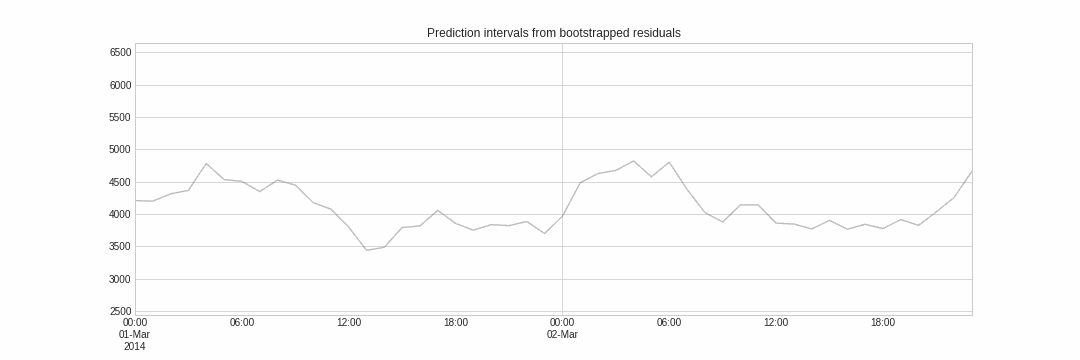

In [ ]:
# Descarga de datos
# ==================
datos = fetch_dataset(name='h2o_exog', raw=True, verbose=False)

# Preparación del dato
# ===================
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()

# Separación datos train-test
# =========================
steps = 36
datos_train = datos[:-steps]
datos_test  = datos[-steps:]
print(f"Fechas train : {datos_train.index.min()} --- {datos_train.index.max()}  (n={len(datos_train)})")
print(f"Fechas test  : {datos_test.index.min()} --- {datos_test.index.max()}  (n={len(datos_test)})")

Fechas train : 1992-04-01 00:00:00 --- 2005-06-01 00:00:00  (n=159)
Fechas test  : 2005-07-01 00:00:00 --- 2008-06-01 00:00:00  (n=36)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Crear y entrenar forecaster
# ===========================
forecaster = ForecasterAutoreg(
                    regressor = Ridge(alpha=0.1, random_state=765),
                    lags = 15
             )
forecaster.fit(y=datos_train['y'])

# Intervalos de predicción
# ===========================
predicciones = forecaster.predict_interval(
                    steps    = steps,
                    interval = [1, 99],
                    n_boot   = 500
               )
predicciones.head(5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


pred  lower_bound  upper_bound
2005-07-01  0.970598     0.788690     1.087272
2005-08-01  0.990932     0.871233     1.102724
2005-09-01  1.149609     1.006556     1.273330
2005-10-01  1.194584     1.033330     1.310059
2005-11-01  1.231744     1.075307     1.353879

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Error de test (mse): 0.01046508616179124


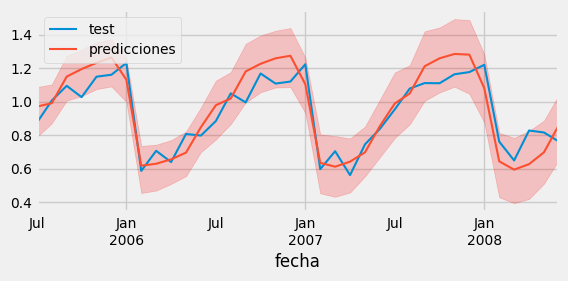

In [ ]:
# Error de predicción
# ===================
error_mse = mean_squared_error(
                y_true = datos_test['y'],
                y_pred = predicciones['pred']
            )
print(f"Error de test (mse): {error_mse}")

# Gráfico
# ===================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos_test['y'].plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend(loc='upper left');

Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  0%|          | 0/3 [00:00<?, ?it/s]

mean_squared_error
0            0.012641

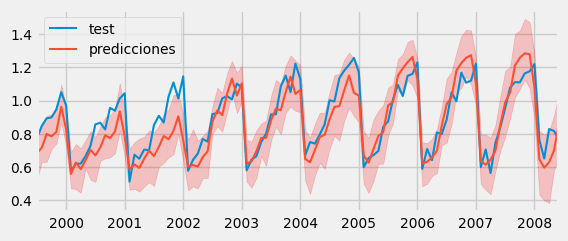

In [ ]:
# Backtest con intervalos de predicción
# ======================================
n_backtesting = 36*3 # Se separan para el backtest los últimos 9 años
steps = 36
forecaster = ForecasterAutoreg(
                regressor = Ridge(alpha=0.1, random_state=765),
                lags      = 15
             )
metrica, predicciones = backtesting_forecaster(
                            forecaster         = forecaster,
                            y                  = datos['y'],
                            initial_train_size = len(datos) - n_backtesting,
                            fixed_train_size   = False,
                            steps              = steps,
                            metric             = 'mean_squared_error',
                            refit              = True,
                            interval           = [1, 99],
                            n_boot             = 100,
                            n_jobs             = 'auto',
                            verbose            = True
                       )
display(metrica)

# Gráfico
# ==============================================================================
fig, ax = plt.subplots(figsize=(6, 2.5))
datos.loc[predicciones.index, 'y'].plot(ax=ax, label='test')
predicciones['pred'].plot(ax=ax, label='predicciones')
ax.fill_between(
    predicciones.index,
    predicciones['lower_bound'],
    predicciones['upper_bound'],
    color = 'red',
    alpha = 0.2
)
ax.legend();

In [ ]:
# Cobertura del intervalo predicho
# ================================
dentro_intervalo = np.where(
                     (datos.loc[predicciones.index, 'y'] >= predicciones['lower_bound']) & \
                     (datos.loc[predicciones.index, 'y'] <= predicciones['upper_bound']),
                     True,
                     False
                   )

cobertura = dentro_intervalo.mean()
print(f"Cobertura del intervalo predicho: {round(100*cobertura, 2)} %")

Cobertura del intervalo predicho: 83.33 %


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


# **Métrica custom**

En los procesos de backtesting (backtesting_forecaster) y optimización de hiperparámetros (grid_search_forecaster), además de las métricas mean_squared_error, mean_absolute_error y mean_absolute_percentage_error, el usuario puede utilizar cualquier función que desee siempre y cuando cumpla lo siguiente:

Tiene como argumentos:

y_true: verdaderos valores de la serie.

y_pred: valores predichos.

Devuelve un valor numérico (float o int).

El modelo es mejor cuanto menor es la métrica. Esto únicamente es necesario si se quiere que la función grid_search_forecaster reentrene automáticamente el mejor modelo encontrado.

Gracias a esta flexibilidad, es posible evaluar la capacidad predictiva del modelo con métricas aplicables a escenarios muy diversos. Por ejemplo:

Considerar únicamente determinados meses, días u horas.

Considerar únicamente fechas que sean festivos.

Considerar únicamente el último step del horizonte predicho.

Véase un ejemplo en el que se quiere predecir un horizonte de 12 meses, pero únicamente considerar los últimos 3 meses de cada año para calcular la métrica de interés.

In [ ]:
# Métrica custom
# ===============
def custom_metric(y_true, y_pred):
    '''
    Calcular el mean_absolute_error utilizando únicamente las predicciones de
    los últimos 3 meses del año.
    '''
    mask = y_true.index.month.isin([10, 11, 12])
    metric = mean_absolute_error(y_true[mask], y_pred[mask])

    return metric

In [ ]:
# Backtesting
# ============
steps = 36
n_backtesting = 36*3 # Se separan para el backtest los últimos 9 años
metrica, predicciones_backtest = backtesting_forecaster(
                                    forecaster         = forecaster,
                                    y                  = datos['y'],
                                    initial_train_size = len(datos) - n_backtesting,
                                    fixed_train_size   = False,
                                    steps              = steps,
                                    refit              = True,
                                    metric             = custom_metric,
                                    n_jobs             = 'auto',
                                    verbose            = True
                                 )
metrica

Information of backtesting process
----------------------------------
Number of observations used for initial training: 87
Number of observations used for backtesting: 108
    Number of folds: 3
    Number skipped folds: 0 
    Number of steps per fold: 36
    Number of steps to exclude from the end of each train set before test (gap): 0

Fold: 0
    Training:   1992-04-01 00:00:00 -- 1999-06-01 00:00:00  (n=87)
    Validation: 1999-07-01 00:00:00 -- 2002-06-01 00:00:00  (n=36)
Fold: 1
    Training:   1992-04-01 00:00:00 -- 2002-06-01 00:00:00  (n=123)
    Validation: 2002-07-01 00:00:00 -- 2005-06-01 00:00:00  (n=36)
Fold: 2
    Training:   1992-04-01 00:00:00 -- 2005-06-01 00:00:00  (n=159)
    Validation: 2005-07-01 00:00:00 -- 2008-06-01 00:00:00  (n=36)



  0%|          | 0/3 [00:00<?, ?it/s]

custom_metric
0       0.128159

# **Guardar y cargar modelos**

Los modelos generados con Skforecast se pueden cargar y guardar usando las librerías Pickle o Joblib**. A continuación se muestra un ejemplo sencillo utilizando. Para facilitar el proceso, dos funciones están disponibles: save_forecaster y load_forecaster. A continuación, se muestra un sencillo ejemplo. Para más información cosultar: skforecast save and load forecaster.

In [ ]:
# Crear forecaster
# =================
forecaster = ForecasterAutoreg(RandomForestRegressor(random_state=123), lags=3)
forecaster.fit(y=datos['y'])
forecaster.predict(steps=3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2008-07-01    0.751967
2008-08-01    0.826505
2008-09-01    0.879444
Freq: MS, Name: pred, dtype: float64

In [ ]:
# Guardar modelo
# ==============================================================================
save_forecaster(forecaster, file_name='forecaster.joblib', verbose=False)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
# Cargar modelo
# ==============================================================================
forecaster_cargado = load_forecaster('forecaster.joblib')

ForecasterAutoreg 
Regressor: RandomForestRegressor(random_state=123) 
Lags: [1 2 3] 
Transformer for y: None 
Transformer for exog: None 
Window size: 3 
Weight function included: False 
Differentiation order: None 
Exogenous included: False 
Exogenous variables names: None 
Training range: [Timestamp('1992-04-01 00:00:00'), Timestamp('2008-06-01 00:00:00')] 
Training index type: DatetimeIndex 
Training index frequency: MS 
Regressor parameters: {'bootstrap': True, 'ccp_alpha': 0.0, 'criterion': 'squared_error', 'max_depth': None, 'max_features': 1.0, 'max_leaf_nodes': None, 'max_samples': None, 'min_impurity_decrease': 0.0, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'monotonic_cst': None, 'n_estimators': 100, 'n_jobs': None, 'oob_score': False, 'random_state': 123, 'verbose': 0, 'warm_start': False} 
fit_kwargs: {} 
Creation date: 2024-12-16 00:19:25 
Last fit date: 2024-12-16 00:19:25 
Skforecast version: 0.13.0 
Python version: 3.10.12 
Forecast

In [ ]:
# Predicciones
# =============
forecaster_cargado.predict(steps=3)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2008-07-01    0.751967
2008-08-01    0.826505
2008-09-01    0.879444
Freq: MS, Name: pred, dtype: float64

# **⚠ Warning**

Cuando se utilizan funciones personalizadas, como en el caso de ForecasterAutoregCustom, la función debe definirse antes de cargar el forecaster. De lo contrario, se producirá un error. Por lo tanto, se recomienda guardar la función en un archivo separado e importarla antes de cargar el forecaster.

# **Uso de modelos en producción**

En los proyectos relacionados con forecasting es frecuente que, como resultado de la etapa de experimentación y desarrollo, se genere un modelo. Para que este modelo consiga un impacto real en el negocio, se tiene que poder poner en producción y generar predicciones cada cierto tiempo, con las que tomar decisiones. Esta necesidad ha guiado en gran medida el desarrollo de la librería Skforecast.

Supóngase un caso de uso en el que se han de generar predicciones de forma semanal, por ejemplo, cada lunes el modelo tiene que predecir el resto de la semana. Una forma de conseguir este comportamiento es reentrenando el modelo semanalmente justo antes de que se ejecute la primera predicción y llamar a continuación al método predict del objeto forecaster.

Esta estrategia, si bien es sencilla, puede no ser posible de utilizar en la práctica por varias razones:

El entrenamiento del modelo es muy costoso y no puede ejecutarse con tanta frecuencia.

Ya no se dispone del histórico con el que se entrenó el modelo.

La frecuencia de predicción es tan elevada que no se dispone de tiempo para entrenar el modelo entre predicción y predicción.

En estos casos, es necesario que el modelo pueda ejecutarse en cualquier momento aunque no se haya entrenado recientemente.

Todos los modelos generados por la librería Skforecast disponen en su método predict del argumento last_window. Gracias a él, se pueden proporcionar únicamente los valores pasados que necesita el modelo para crear los predictores autorregresivos (lags) y así generar las predicciones sin necesidad de reentrenar el modelo.

Para una documentación más detallada, visitar: skforecast forecaster en producción.

In [ ]:
# Crear y entrenar forecaster
# ===========================
forecaster = ForecasterAutoreg(
                regressor = RandomForestRegressor(random_state=123),
                lags = 6
             )
forecaster.fit(y=datos_train['y'])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


En este caso, dado que el modelo utiliza como predictores los últimos 6 lags, last_window debe de contener como mínimo los 6 valores previos al momento donde se quiere iniciar la predicción.

In [ ]:
# Predecir con last_window
# ==========================
last_window = datos_test['y'][-6:]
forecaster.predict(last_window=last_window, steps=4)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


2008-07-01    0.757750
2008-08-01    0.836313
2008-09-01    0.877668
2008-10-01    0.911734
Freq: MS, Name: pred, dtype: float64

Si el forecaster utiliza variables exógenas, además de last_window, se le deben proporcionar los valores futuros de las variables exógenas mediante el argumento exog.

# **Otras funcionalidades**

Son muchas las funcionalidades que ofrece skforecast como para ser mostradas en un único documento. El siguiente listado contiene referencias a más contenido formativo:

Global models: Multi-series forecasting

Global models: Multivariate forecasting

Weighted time series forecasting

Forecasting series temporales con valores ausentes

Explicabilidad de Forecasters con shap values

# **Casos de uso**

Te invitamos a explorar nuestra colección de ejemplos y tutoriales, donde encontrarás múltiples casos de uso que te brindarán una visión práctica de cómo aplicar esta poderosa biblioteca. Ejemplos y tutoriales.

In [ ]:

# Carga de datos desde el archivo proporcionado
import pandas as pd

csv_path = '/content/h2oexog.csv'
datos = pd.read_csv(csv_path)

# Preparando el dataset
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()
datos.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


y    exog_1    exog_2
fecha                                   
1992-04-01  0.379808  0.958792  1.166029
1992-05-01  0.361801  0.951993  1.117859
1992-06-01  0.410534  0.952955  1.067942
1992-07-01  0.483389  0.958078  1.097376
1992-08-01  0.475463  0.956370  1.122199

In [ ]:

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(datos) * 0.8)
datos_train = datos.iloc[:train_size]
datos_test = datos.iloc[train_size:]

print(f"Tamaño de datos de entrenamiento: {len(datos_train)}")
print(f"Tamaño de datos de prueba: {len(datos_test)}")


Tamaño de datos de entrenamiento: 156
Tamaño de datos de prueba: 39


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Entrenamiento del modelo SARIMAX
sarimax_model = SARIMAX(
    endog=datos_train['y'],
    exog=datos_train[['exog_1', 'exog_2']],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12)
)
sarimax_results = sarimax_model.fit()

# Resumen del modelo
print(sarimax_results.summary())


<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen impo

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 251.037
Date:                            Mon, 16 Dec 2024   AIC                           -488.074
Time:                                    00:19:29   BIC                           -467.334
Sample:                                04-01-1992   HQIC                          -479.647
                                     - 03-01-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog_1        -0.3255      0.249     -1.310      0.190      -0.813       0.162
exog_2         1.2301      0.250   

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


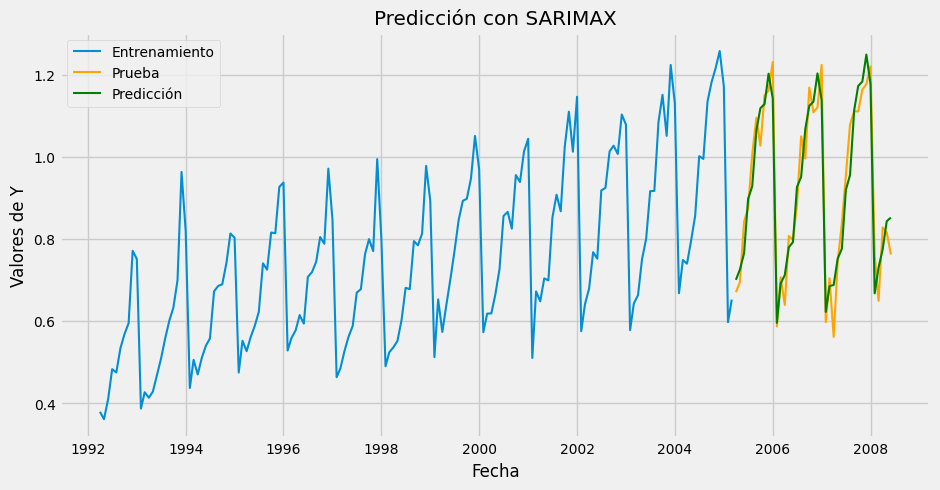

In [ ]:

# Predicción usando el modelo SARIMAX entrenado
predicciones = sarimax_results.predict(
    start=datos_test.index[0],
    end=datos_test.index[-1],
    exog=datos_test[['exog_1', 'exog_2']]
)

# Visualización de los resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(datos_train.index, datos_train['y'], label='Entrenamiento')
plt.plot(datos_test.index, datos_test['y'], label='Prueba', color='orange')
plt.plot(datos_test.index, predicciones, label='Predicción', color='green')
plt.xlabel('Fecha')
plt.ylabel('Valores de Y')
plt.title('Predicción con SARIMAX')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


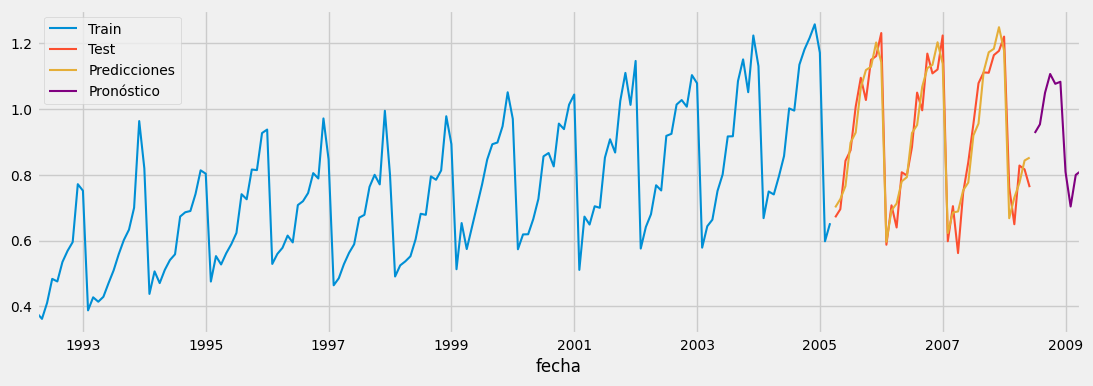

In [ ]:
# Ajustar el índice de predicciones futuras
inicio_pronostico = datos_test.index[-1] + pd.DateOffset(months=1)
predicciones_nuevas.index = pd.date_range(start=inicio_pronostico, periods=10, freq=datos.index.freq)

# Graficar los resultados
fig, ax = plt.subplots(figsize=(12, 4))
datos_train['y'].plot(ax=ax, label='Train')
datos_test['y'].plot(ax=ax, label='Test')
predicciones.plot(ax=ax, label='Predicciones')
predicciones_nuevas.plot(ax=ax, label='Pronóstico', color='purple')
ax.legend()
plt.show()


In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluación del modelo
mse = mean_squared_error(datos_test['y'], predicciones)
mae = mean_absolute_error(datos_test['y'], predicciones)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Error absoluto medio (MAE): {mae}")


Error cuadrático medio (MSE): 0.0038180689841956716
Error absoluto medio (MAE): 0.05212741965523747


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

# Carga de datos desde el archivo proporcionado
import pandas as pd

csv_path = '/content/h2oexog.csv'
datos = pd.read_csv(csv_path)

# Preparando el dataset
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()
datos.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


y    exog_1    exog_2
fecha                                   
1992-04-01  0.379808  0.958792  1.166029
1992-05-01  0.361801  0.951993  1.117859
1992-06-01  0.410534  0.952955  1.067942
1992-07-01  0.483389  0.958078  1.097376
1992-08-01  0.475463  0.956370  1.122199

In [ ]:

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(datos) * 0.8)
datos_train = datos.iloc[:train_size]
datos_test = datos.iloc[train_size:]

print(f"Tamaño de datos de entrenamiento: {len(datos_train)}")
print(f"Tamaño de datos de prueba: {len(datos_test)}")


Tamaño de datos de entrenamiento: 156
Tamaño de datos de prueba: 39


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Entrenamiento del modelo SARIMAX
sarimax_model = SARIMAX(
    endog=datos_train['y'],
    exog=datos_train[['exog_1', 'exog_2']],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12)
)
sarimax_results = sarimax_model.fit()

# Resumen del modelo
print(sarimax_results.summary())


/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 251.037
Date:                            Mon, 16 Dec 2024   AIC                           -488.074
Time:                                    00:19:34   BIC                           -467.334
Sample:                                04-01-1992   HQIC                          -479.647
                                     - 03-01-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog_1        -0.3255      0.249     -1.310      0.190      -0.813       0.162
exog_2         1.2301      0.250   

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


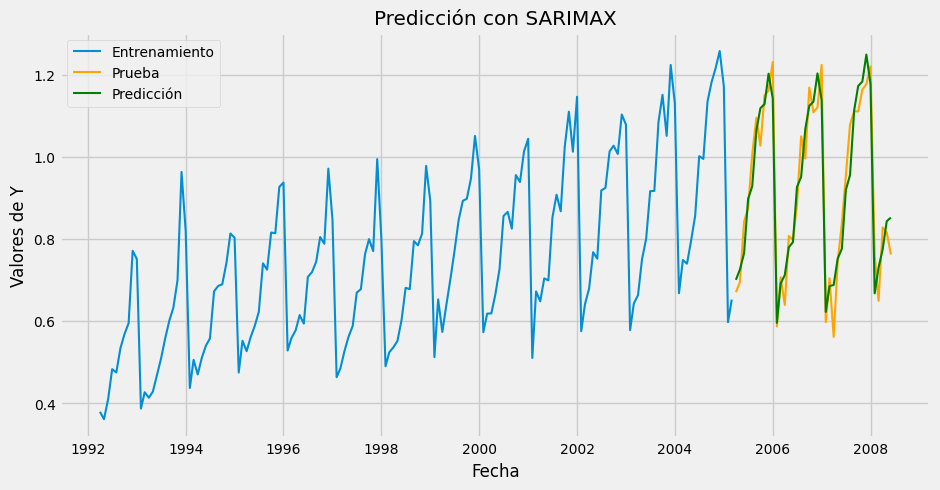

In [ ]:

# Predicción usando el modelo SARIMAX entrenado
predicciones = sarimax_results.predict(
    start=datos_test.index[0],
    end=datos_test.index[-1],
    exog=datos_test[['exog_1', 'exog_2']]
)

# Visualización de los resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(datos_train.index, datos_train['y'], label='Entrenamiento')
plt.plot(datos_test.index, datos_test['y'], label='Prueba', color='orange')
plt.plot(datos_test.index, predicciones, label='Predicción', color='green')
plt.xlabel('Fecha')
plt.ylabel('Valores de Y')
plt.title('Predicción con SARIMAX')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


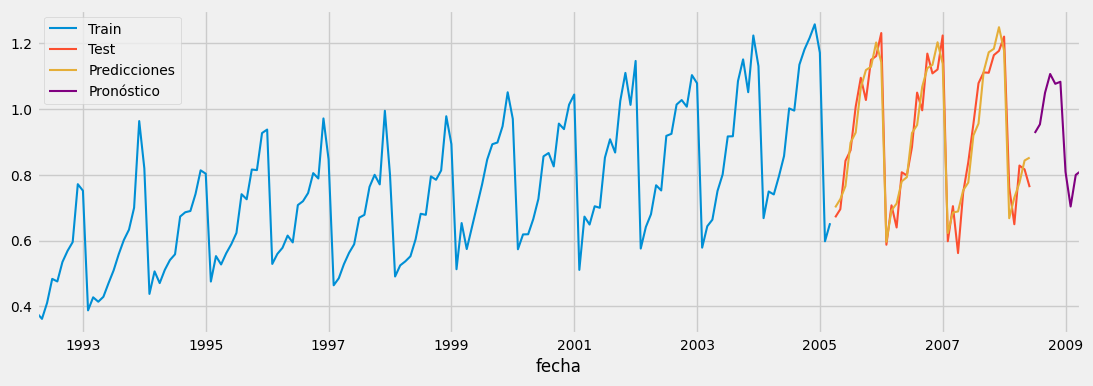

In [ ]:
# Ajustar el índice de predicciones futuras
inicio_pronostico = datos_test.index[-1] + pd.DateOffset(months=1)
predicciones_nuevas.index = pd.date_range(start=inicio_pronostico, periods=10, freq=datos.index.freq)

# Graficar los resultados
fig, ax = plt.subplots(figsize=(12, 4))
datos_train['y'].plot(ax=ax, label='Train')
datos_test['y'].plot(ax=ax, label='Test')
predicciones.plot(ax=ax, label='Predicciones')
predicciones_nuevas.plot(ax=ax, label='Pronóstico', color='purple')
ax.legend()
plt.show()


In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluación del modelo
mse = mean_squared_error(datos_test['y'], predicciones)
mae = mean_absolute_error(datos_test['y'], predicciones)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Error absoluto medio (MAE): {mae}")


Error cuadrático medio (MSE): 0.0038180689841956716
Error absoluto medio (MAE): 0.05212741965523747


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

# Carga de datos desde el archivo proporcionado
import pandas as pd

csv_path = '/content/h2oexog.csv'
datos = pd.read_csv(csv_path)

# Preparando el dataset
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')
datos = datos.set_index('fecha')
datos = datos.asfreq('MS')
datos = datos.sort_index()
datos.head()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


y    exog_1    exog_2
fecha                                   
1992-04-01  0.379808  0.958792  1.166029
1992-05-01  0.361801  0.951993  1.117859
1992-06-01  0.410534  0.952955  1.067942
1992-07-01  0.483389  0.958078  1.097376
1992-08-01  0.475463  0.956370  1.122199

In [ ]:

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(datos) * 0.8)
datos_train = datos.iloc[:train_size]
datos_test = datos.iloc[train_size:]

print(f"Tamaño de datos de entrenamiento: {len(datos_train)}")
print(f"Tamaño de datos de prueba: {len(datos_test)}")


Tamaño de datos de entrenamiento: 156
Tamaño de datos de prueba: 39


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Entrenamiento del modelo SARIMAX
sarimax_model = SARIMAX(
    endog=datos_train['y'],
    exog=datos_train[['exog_1', 'exog_2']],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12)
)
sarimax_results = sarimax_model.fit()

# Resumen del modelo
print(sarimax_results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 251.037
Date:                            Mon, 16 Dec 2024   AIC                           -488.074
Time:                                    00:19:38   BIC                           -467.334
Sample:                                04-01-1992   HQIC                          -479.647
                                     - 03-01-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog_1        -0.3255      0.249     -1.310      0.190      -0.813       0.162
exog_2         1.2301      0.250   

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


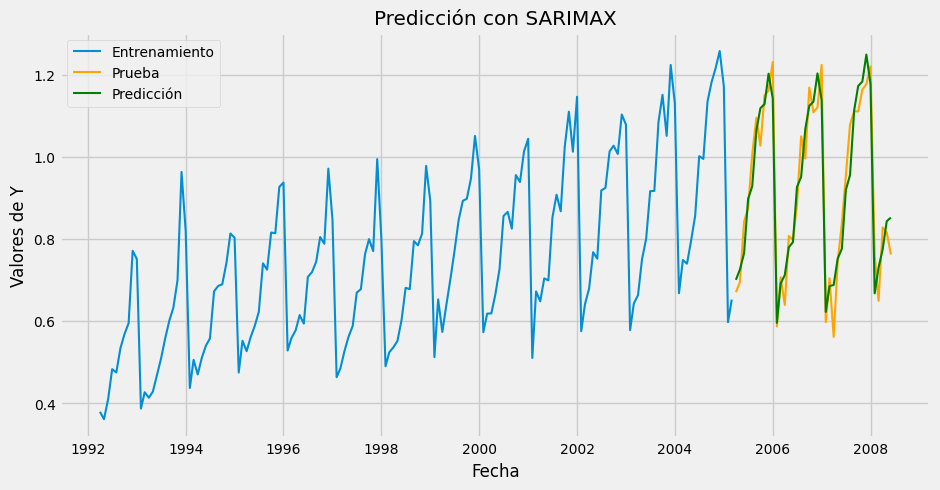

In [ ]:

# Predicción usando el modelo SARIMAX entrenado
predicciones = sarimax_results.predict(
    start=datos_test.index[0],
    end=datos_test.index[-1],
    exog=datos_test[['exog_1', 'exog_2']]
)

# Visualización de los resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(datos_train.index, datos_train['y'], label='Entrenamiento')
plt.plot(datos_test.index, datos_test['y'], label='Prueba', color='orange')
plt.plot(datos_test.index, predicciones, label='Predicción', color='green')
plt.xlabel('Fecha')
plt.ylabel('Valores de Y')
plt.title('Predicción con SARIMAX')
plt.legend()
plt.show()


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-110-eacada4c80bf>:9: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fechas_futuras = pd.date_range(


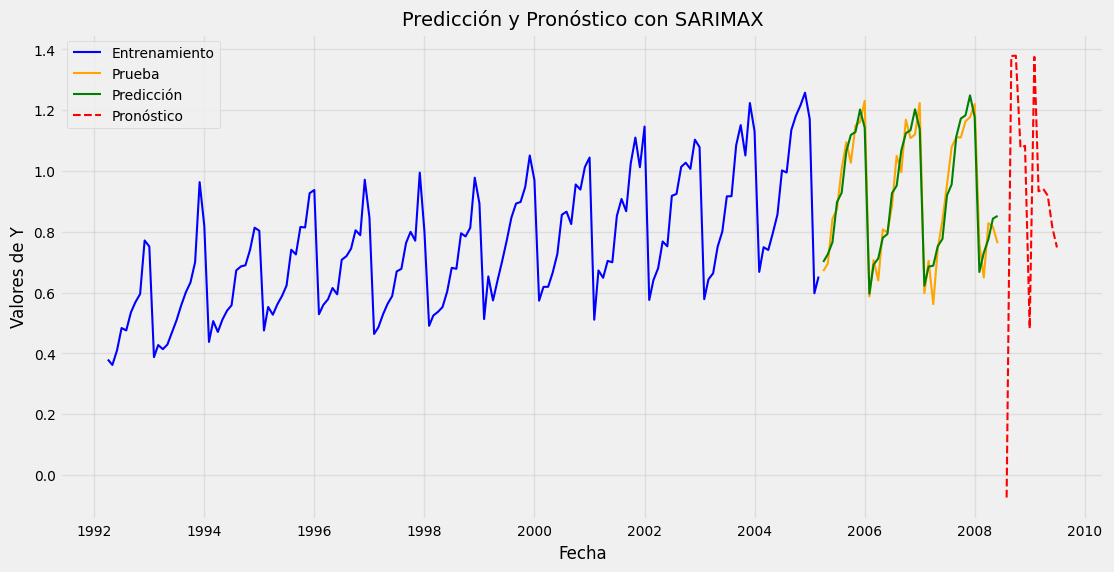

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Definir horizonte de pronóstico
forecast_horizon = 12  # Número de pasos hacia adelante para el pronóstico

# Generar fechas para el pronóstico
fechas_futuras = pd.date_range(
    start=datos_test.index[-1],
    periods=forecast_horizon + 1,
    freq='M'
)[1:]

# Crear variables exógenas futuras (ejemplo, ajusta según tus datos reales)
# Asegúrate de que coincidan con las variables utilizadas en el modelo
futuras_exog = pd.DataFrame({
    'exog_1': np.random.rand(forecast_horizon),  # Valores simulados
    'exog_2': np.random.rand(forecast_horizon)
}, index=fechas_futuras)

# Generar pronóstico
forecast = sarimax_results.forecast(
    steps=forecast_horizon,
    exog=futuras_exog
)

# Ajustar el pronóstico si hay diferencias en la escala
ajuste = datos_test['y'].mean() - forecast.mean()
forecast_ajustado = forecast + ajuste

# Visualización
plt.figure(figsize=(12, 6))

# Datos de entrenamiento
plt.plot(datos_train.index, datos_train['y'], label='Entrenamiento', color='blue', linewidth=1.5)

# Datos de prueba
plt.plot(datos_test.index, datos_test['y'], label='Prueba', color='orange', linewidth=1.5)

# Predicciones en los datos de prueba
plt.plot(datos_test.index, predicciones, label='Predicción', color='green', linewidth=1.5)

# Pronóstico ajustado
plt.plot(fechas_futuras, forecast_ajustado, label='Pronóstico', color='red', linestyle='--', linewidth=1.5)

# Configuración de etiquetas y título
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Valores de Y', fontsize=12)
plt.title('Predicción y Pronóstico con SARIMAX', fontsize=14)
plt.legend(loc='upper left', fontsize=10)
plt.grid(alpha=0.5)

# Mostrar gráfico
plt.show()


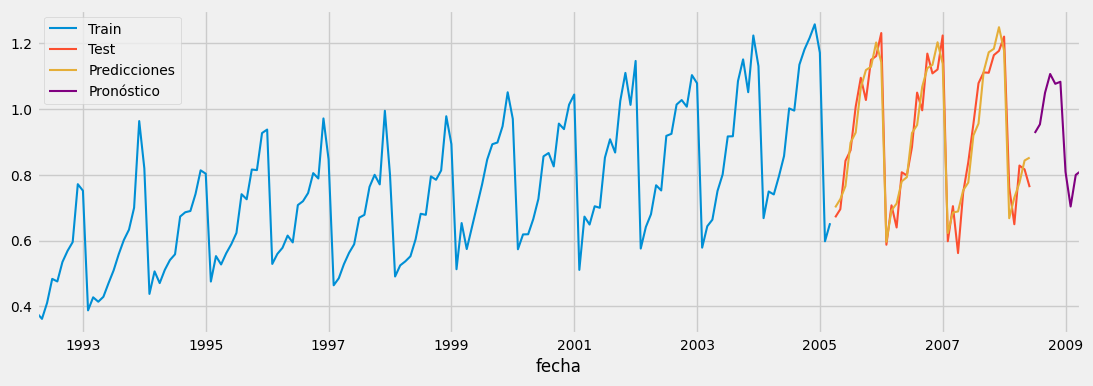

In [ ]:
# Ajustar el índice de predicciones futuras
inicio_pronostico = datos_test.index[-1] + pd.DateOffset(months=1)
predicciones_nuevas.index = pd.date_range(start=inicio_pronostico, periods=10, freq=datos.index.freq)

# Graficar los resultados
fig, ax = plt.subplots(figsize=(12, 4))
datos_train['y'].plot(ax=ax, label='Train')
datos_test['y'].plot(ax=ax, label='Test')
predicciones.plot(ax=ax, label='Predicciones')
predicciones_nuevas.plot(ax=ax, label='Pronóstico', color='purple')
ax.legend()
plt.show()


In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluación del modelo
mse = mean_squared_error(datos_test['y'], predicciones)
mae = mean_absolute_error(datos_test['y'], predicciones)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Error absoluto medio (MAE): {mae}")


Error cuadrático medio (MSE): 0.0038180689841956716
Error absoluto medio (MAE): 0.05212741965523747


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
# Carga de datos desde el archivo Excel
import pandas as pd

# Ruta del archivo Excel
csv_path = '/content/datos_ingenieria.xlsx'

# Cargar los datos desde el archivo
datos = pd.read_excel(csv_path)

# Preparando el dataset
datos['fecha'] = pd.to_datetime(datos['fecha'], format='%Y-%m-%d')  # Convertir la columna 'fecha' a datetime
datos = datos.set_index('fecha')  # Establecer 'fecha' como índice
datos = datos.asfreq('MS')  # Asegurar que los datos tengan frecuencia mensual (MS: inicio de mes)
datos = datos.sort_index()  # Ordenar los datos por índice (fecha)

# Mostrar las primeras filas para verificar los datos cargados
datos.head()


temperatura      presion  velocviento   humendad  produc_energia
fecha                                                                       
1910-01-01    17.490802  1015.791540     3.285316  48.826402      454.477965
1910-02-01    13.410482  1022.876191     6.234441  44.349338      435.926612
1910-03-01    16.506607  1010.863381    18.945667  70.930569      934.331090
1910-04-01    12.391885  1017.389377    16.057069  86.861424      956.263008
1910-05-01    26.148803  1023.517370     1.341530  51.038481      308.752387

In [ ]:

# Dividir los datos en conjuntos de entrenamiento y prueba
train_size = int(len(datos) * 0.8)
datos_train = datos.iloc[:train_size]
datos_test = datos.iloc[train_size:]

print(f"Tamaño de datos de entrenamiento: {len(datos_train)}")
print(f"Tamaño de datos de prueba: {len(datos_test)}")


Tamaño de datos de entrenamiento: 156
Tamaño de datos de prueba: 39


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:

from statsmodels.tsa.statespace.sarimax import SARIMAX

# Entrenamiento del modelo SARIMAX
sarimax_model = SARIMAX(
    endog=datos_train['y'],
    exog=datos_train[['exog_1', 'exog_2']],
    order=(1, 1, 1),
    seasonal_order=(1, 1, 1, 12)
)
sarimax_results = sarimax_model.fit()

# Resumen del modelo
print(sarimax_results.summary())


                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  156
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 12)   Log Likelihood                 251.037
Date:                            Mon, 16 Dec 2024   AIC                           -488.074
Time:                                    00:19:42   BIC                           -467.334
Sample:                                04-01-1992   HQIC                          -479.647
                                     - 03-01-2005                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
exog_1        -0.3255      0.249     -1.310      0.190      -0.813       0.162
exog_2         1.2301      0.250   

/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


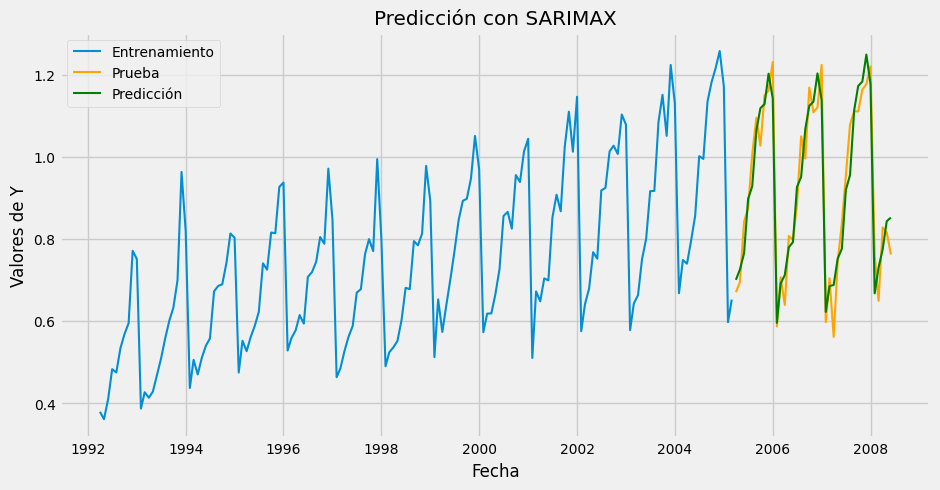

In [ ]:

# Predicción usando el modelo SARIMAX entrenado
predicciones = sarimax_results.predict(
    start=datos_test.index[0],
    end=datos_test.index[-1],
    exog=datos_test[['exog_1', 'exog_2']]
)

# Visualización de los resultados
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(datos_train.index, datos_train['y'], label='Entrenamiento')
plt.plot(datos_test.index, datos_test['y'], label='Prueba', color='orange')
plt.plot(datos_test.index, predicciones, label='Predicción', color='green')
plt.xlabel('Fecha')
plt.ylabel('Valores de Y')
plt.title('Predicción con SARIMAX')
plt.legend()
plt.show()


In [ ]:
# Ejemplo de generación de variables exógenas futuras
import pandas as pd
import numpy as np

fechas_futuras = pd.date_range(start=datos_test.index[-1], periods=forecast_horizon + 1, freq='M')[1:]
futuras_exog = pd.DataFrame({
    'exog_1': np.random.rand(forecast_horizon),  # Reemplazar con valores reales o estimados
    'exog_2': np.random.rand(forecast_horizon)
}, index=fechas_futuras)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
<ipython-input-117-3da0b36cfe91>:5: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  fechas_futuras = pd.date_range(start=datos_test.index[-1], periods=forecast_horizon + 1, freq='M')[1:]


In [ ]:
# Pronóstico con variables exógenas futuras
forecast = sarimax_results.forecast(
    steps=forecast_horizon,
    exog=futuras_exog
)


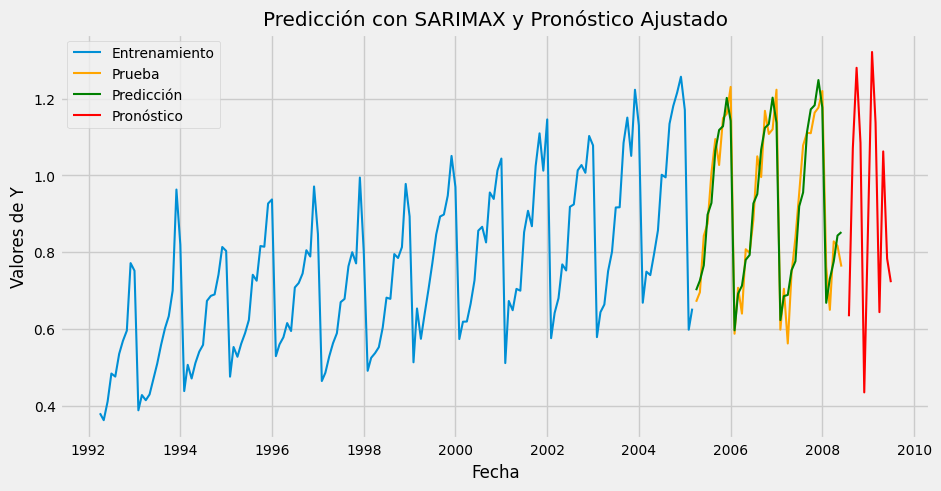

In [ ]:
# Calcular el ajuste promedio entre las predicciones y los datos reales
ajuste = datos_test['y'].mean() - forecast.mean()

# Ajustar el pronóstico para que coincida con la escala de los datos anteriores
forecast_ajustado = forecast + ajuste

# Visualización ajustada
plt.figure(figsize=(10, 5))
plt.plot(datos_train.index, datos_train['y'], label='Entrenamiento')
plt.plot(datos_test.index, datos_test['y'], label='Prueba', color='orange')
plt.plot(datos_test.index, predicciones, label='Predicción', color='green')
plt.plot(futuras_exog.index, forecast_ajustado, label='Pronóstico', color='red')
plt.xlabel('Fecha')
plt.ylabel('Valores de Y')
plt.title('Predicción con SARIMAX y Pronóstico Ajustado')
plt.legend()
plt.show()


In [ ]:

from sklearn.metrics import mean_squared_error, mean_absolute_error

# Evaluación del modelo
mse = mean_squared_error(datos_test['y'], predicciones)
mae = mean_absolute_error(datos_test['y'], predicciones)

print(f"Error cuadrático medio (MSE): {mse}")
print(f"Error absoluto medio (MAE): {mae}")


Error cuadrático medio (MSE): 0.0038180689841956716
Error absoluto medio (MAE): 0.05212741965523747


# **Casos de uso**

Te invitamos a explorar nuestra colección de ejemplos y tutoriales, donde encontrarás múltiples casos de uso que te te brindarán una visión práctica de cómo aplicar esta poderosa biblioteca. Ejemplos y tutoriales.


# **Información de sesión**

In [ ]:
!pip install -q session-info


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.6/83.6 kB 4.8 MB/s eta 0:00:00


In [ ]:
import session_info
session_info.show(html=False)

<frozen importlib._bootstrap>:914: ImportWarning: _PyDrive2ImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _GenerativeAIImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _OpenCVImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: APICoreClientInfoImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:914: ImportWarning: _AltairImportHook.find_spec() not found; falling back to find_module()


-----
matplotlib          3.8.0
numpy               1.26.4
pandas              2.2.2
session_info        1.0.0
shap                0.46.0
skforecast          0.13.0
sklearn             1.5.2
statsmodels         0.14.4
-----
IPython             7.34.0
jupyter_client      6.1.12
jupyter_core        5.7.2
notebook            6.5.5
-----
Python 3.10.12 (main, Nov  6 2024, 20:22:13) [GCC 11.4.0]
Linux-6.1.85+-x86_64-with-glibc2.35
-----
Session information updated at 2024-12-16 00:19


# **Bibliografía**
Hyndman, R.J., & Athanasopoulos, G. (2021) Forecasting: principles and practice, 3rd edition, OTexts: Melbourne, Australia.

Time Series Analysis and Forecasting with ADAM Ivan Svetunkov

Joseph, M. (2022). Modern time series forecasting with Python: Explore industry-ready time series forecasting using modern machine learning and Deep Learning. Packt Publishing.

Python for Finance: Mastering Data-Driven Finance